**Import Library**

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import date
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import os, sys
import pickle
from tqdm.notebook import tqdm

import warnings 
warnings.filterwarnings('ignore')

mpl.rc('font', family='New Gulim')
mpl.rc('axes', unicode_minus=False)

%matplotlib inline

**Import Data**

In [2]:
# 2019년 실적데이터
train_raw = pd.read_excel('./Data/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터_v1_200818.xlsx')

with open('C:/bigcon/pickles/train_raw.pkl', 'wb') as f: # 원 Train 데이터 Pickle로 저장
    pickle.dump(train_raw, f)
    
train_raw = train_raw.rename(columns=train_raw.iloc[0])[1:].reset_index(drop=True)
train_raw = train_raw.loc[train_raw['상품군']!='무형'].reset_index(drop=True) # 상품군이 무형인 경우 예측하지 않음. 모두 0으로 처리 (*빅콘테스트 공지 참조)
train_raw['취급액'] = train_raw['취급액'].fillna(0)
train_raw = train_raw.loc[train_raw['취급액'] != 0].reset_index(drop = True) # 취급액 없음 변경

In [3]:
# 2020년 6월 실적데이터
test_raw = pd.read_excel('./Data/2020 빅콘테스트 데이터분석분야-챔피언리그_2020년 6월 판매실적예측데이터(평가데이터).xlsx')

with open('./pickles/test_raw.pkl', 'wb') as f: # 원 Test 데이터 Pickle로 저장
    pickle.dump(test_raw, f)
    
test_raw = test_raw.rename(columns=test_raw.iloc[0])[1:]
test_raw_mu = test_raw.loc[test_raw['상품군']=='무형'].reset_index() # 상품군이 무형인 경우 예측하지 않음. 모두 0으로 처리 (*빅콘테스트 공지 참조)
test_raw = test_raw.loc[test_raw['상품군']!='무형'].reset_index()

**분당 판매량** 변수를 생성하여, 판매량의 추세를 살펴보자

# EDA

In [4]:
print('Train 데이터 형태 : ', train_raw.shape) # (35379, 10)
print('-'*50)
print(train_raw.head(3))
print('-'*50)
print(train_raw.info())

Train 데이터 형태 :  (35379, 8)
--------------------------------------------------
                  방송일시 노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0  2019-01-01 06:00:00    20  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1  2019-01-01 06:00:00   NaN  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2  2019-01-01 06:20:00    20  100346  201072  테이트 남성 셀린니트3종  의류  39900   

       취급액  
0  2099000  
1  4371000  
2  3262000  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35379 entries, 0 to 35378
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   방송일시    35379 non-null  object
 1   노출(분)   20403 non-null  object
 2   마더코드    35379 non-null  object
 3   상품코드    35379 non-null  object
 4   상품명     35379 non-null  object
 5   상품군     35379 non-null  object
 6   판매단가    35379 non-null  object
 7   취급액     35379 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 2.2+ MB
None

In [5]:
train_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
취급액,35379.0,2.310241e+07,2.005790e+07,103000.0,7998500.0,17326000.0,32763000.0,322009000.0


In [6]:
train_raw.isna().sum() # '노출(분)' 변수에 결측값이 14,976개 존재 

방송일시         0
노출(분)    14976
마더코드         0
상품코드         0
상품명          0
상품군          0
판매단가         0
취급액          0
dtype: int64

In [7]:
train_na = train_raw.loc[train_raw['노출(분)'].isna()] # 노출(분)에 결측값이 존재하는 데이터 프레임
train_na.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
1,2019-01-01 06:00:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000
3,2019-01-01 06:20:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000
5,2019-01-01 06:40:00,NaN,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000
26,2019-01-01 14:00:00,NaN,100377,201226,그렉노먼 여성 구스다운 롱 벤치코트,의류,119000,20841000
28,2019-01-01 14:30:00,NaN,100377,201226,그렉노먼 여성 구스다운 롱 벤치코트,의류,119000,47294000


노출(분)이 결측 값이 생기는 이유는 동시에 2개 이상의 상품을 방영했을 때 나타난다.   
- 그래서, 같은 시간대에 방송하는 다른 상품의 노출(분)을 참조하여 아래와 같이 결측값을 대체한다.   

In [8]:
for i in tqdm(range(len(train_raw))):
    if pd.isna(train_raw.loc[i,'노출(분)']):
        train_raw.loc[i,'노출(분)'] = train_raw.loc[(i-1),'노출(분)']

train_raw.tail(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
35369,2019-12-31 23:20:00,20,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,620000
35370,2019-12-31 23:20:00,20,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,1664000
35371,2019-12-31 23:40:00,20,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,9149000
35372,2019-12-31 23:40:00,20,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,15282000
35373,2019-12-31 23:40:00,20,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,2328000
35374,2019-12-31 23:40:00,20,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,10157000
35375,2020-01-01 00:00:00,20,100448,201383,무이자쿠첸압력밥솥 10인용,주방,178000,50929000
35376,2020-01-01 00:00:00,20,100448,201390,일시불쿠첸압력밥솥 10인용,주방,168000,104392000
35377,2020-01-01 00:00:00,20,100448,201384,무이자쿠첸압력밥솥 6인용,주방,158000,13765000
35378,2020-01-01 00:00:00,20,100448,201391,일시불쿠첸압력밥솥 6인용,주방,148000,46608000


알맞게 결측값이 채워진 것을 볼 수 있다.

In [9]:
print('Test 데이터 형태 : ', test_raw.shape)
print('-'*50)
print(test_raw.head(3))
print('-'*50)
print(test_raw.info())

Test 데이터 형태 :  (2716, 9)
--------------------------------------------------
   index                 방송일시 노출(분)    마더코드    상품코드              상품명 상품군  \
0      1  2020-06-01 06:20:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   
1      2  2020-06-01 06:40:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   
2      3  2020-06-01 07:00:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   

    판매단가  취급액  
0  59800  NaN  
1  59800  NaN  
2  59800  NaN  
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2716 entries, 0 to 2715
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   2716 non-null   int64 
 1   방송일시    2716 non-null   object
 2   노출(분)   1617 non-null   object
 3   마더코드    2716 non-null   object
 4   상품코드    2716 non-null   object
 5   상품명     2716 non-null   object
 6   상품군     2716 non-null   object
 7   판매단가    2716 non-null   object
 8   취급액     0 non-null      object
dt

In [10]:
test_raw.isna().sum() # '노출(분)' 변수에 1,099개 결측 값 존재. Train 데이터와 같이 결측 처리

index       0
방송일시        0
노출(분)    1099
마더코드        0
상품코드        0
상품명         0
상품군         0
판매단가        0
취급액      2716
dtype: int64

In [11]:
for i in tqdm(range(len(test_raw))):
    if pd.isna(test_raw.loc[i,'노출(분)']):
        test_raw.loc[i,'노출(분)'] = test_raw.loc[(i-1),'노출(분)']
        
test_raw.head(5)

,index,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액
0,1,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
1,2,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
2,3,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN
3,4,2020-06-01 07:20:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN
4,5,2020-06-01 07:40:00,20,100445,202278,쿠미투니카 쿨 레이시 란쥬쉐이퍼&팬티,속옷,69900,NaN


상품군 별 판매단가의 차이가 매우 크기 때문에, '분당 판매량' 변수를 생성하여 소비자들의 구매 패턴을 비교 분석하기로 한다.

In [12]:
for i in tqdm(range(len(train_raw))):
    if pd.isna(train_raw.loc[i,'노출(분)']):
        train_raw.loc[i,'노출(분)'] = train_raw.loc[(i-1),'노출(분)']

train_raw['판매량'] = [round(train_raw.loc[i,'취급액']/train_raw.loc[i,'판매단가'] # 분당 판매량
                          /train_raw.loc[i,'노출(분)']) for i in range(len(train_raw))] 

**연속형 변수의 탐색**

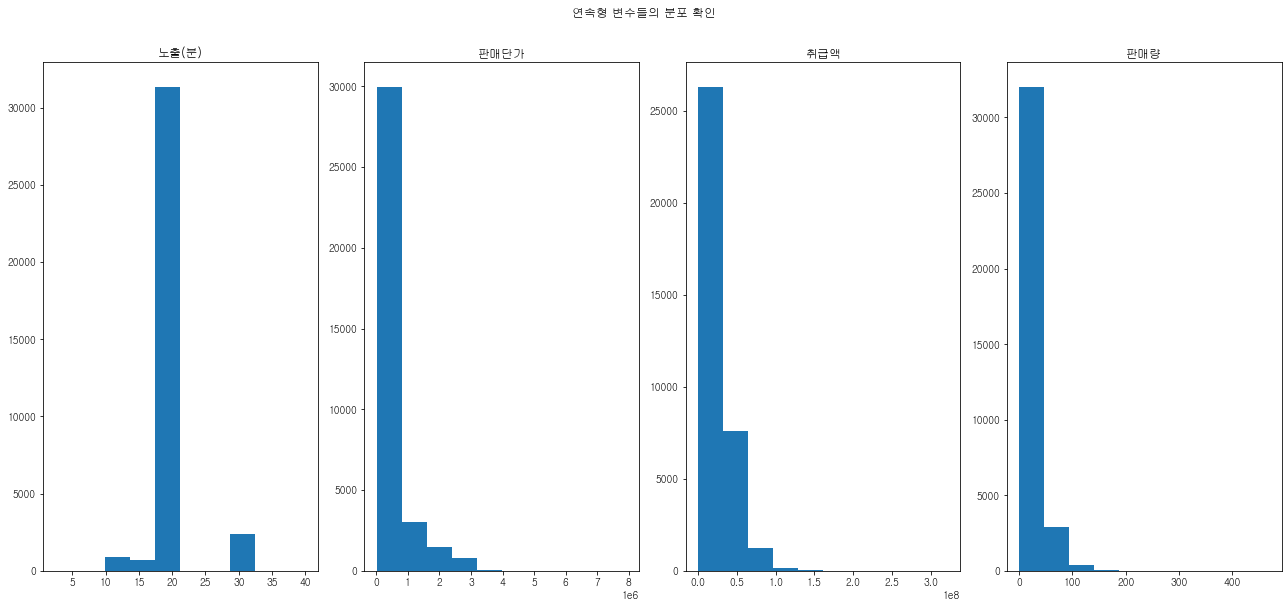

In [13]:
numeric_feature = ['노출(분)', '판매단가', '취급액', '판매량']
suptitle = '연속형 변수들의 분포 확인'
fig, ax = plt.subplots(ncols = 4, figsize = (18, 8))
for i, num in enumerate(numeric_feature):
    ax[i].hist(train_raw[num])
    ax[i].set_title(num)
fig.suptitle(suptitle, position = (0.5, 1.0+0.05))
fig.tight_layout()
plt.savefig(f'./graphs/{suptitle}.png')

- 노출(분)의 분포를 보면, 대부분 15-20분 임을 알 수 있다.

- 판매단가의 분포를 보면, 대부분 100만원을 넘지 않음을 알 수 있다. (x축 단위가 1e6이므로)

- 취급액의 분포를 보면, 대부분 1억을 넘지 않음을 알 수 있다. (x축 단위가 1e8이므로)

- 판매량의 분포를 보면, 대부분 분당 판매량이 100개 아래인 것을 알 수 있다.

## 브랜드 파워   

여름철 보양 ‘팽현숙의 옛날오리부추한판’ 출시…홈쇼핑에서도 대박 행진

예산군 대표쌀 ‘미황’ 홈쇼핑 완판

출처

아이티비즈(http://www.it-b.co.kr/news/articleView.html?idxno=41282)

디트뉴스(http://www.dtnews24.com/news/articleView.html?idxno=573159)

이러한 뉴스 기사를 보면서 유명인 및 특정 브랜드에 대한 선호 현상 확인

유명인 및 특정 브랜드 (지역명, 브랜드명)이 포함된 상품명을 추출하고 판매량을 확인함으로써 브랜드파워 존재 유무 파악해보자

### 농수축

In [14]:
# 브랜드명이 포함된 리스트
industry = ['이봉원', '우리바다', '하늘내린', 'SPC삼립', '바다먹자', '피시원', '천연담아', '소들녘', '영산포', '팽현숙', '농협', '천수봉', '전철우',
 '수협', 'AAE', '구워만든 곡물그대로', '장보고', '양구', '캘리포니아', '김정문', '완도', '이만기', '본죽', '속초','영광','유귀열','최인선',
 '바다원','제주','이경제','궁중','하동','창녕','청도','송도순','임성근','이정섭','현대어찬','하림','예천','김선영','김규흔','참바다','잔다리',
 '목우촌','신세대','김정배','거창','김천','이보은','신안','슬로푸드','우리나라','남해','오세득','구룡포','강레오','통영','고창','조방할매',
 '산머루농원']

industry_df = train_raw.loc[train_raw['상품군']=='농수축'].reset_index(drop=True)

for i in tqdm(range(len(industry_df))):
    for j in industry:
        if j in industry_df.loc[i,'상품명']:
            industry_df.loc[i,'brand'] = j
            
industry_df['brand'] = industry_df['brand'].fillna('no') # 브랜드명이 포함되지 않은 값에는 no를 표시
industry_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-01 15:00:00,20,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,농수축,60900,14113000,12.0,이봉원
1,2019-01-01 15:20:00,20,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,농수축,60900,32395000,27.0,이봉원
2,2019-01-01 15:40:00,20,100496,201497,뽕셰프 이봉원 특갈비탕 12팩,농수축,60900,39669000,33.0,이봉원
3,2019-01-01 16:00:00,20,100322,201479,국내산 손질갑오징어 8팩,농수축,49900,60787000,61.0,no
4,2019-01-01 16:20:00,20,100322,201479,국내산 손질갑오징어 8팩,농수축,49900,115457000,116.0,no


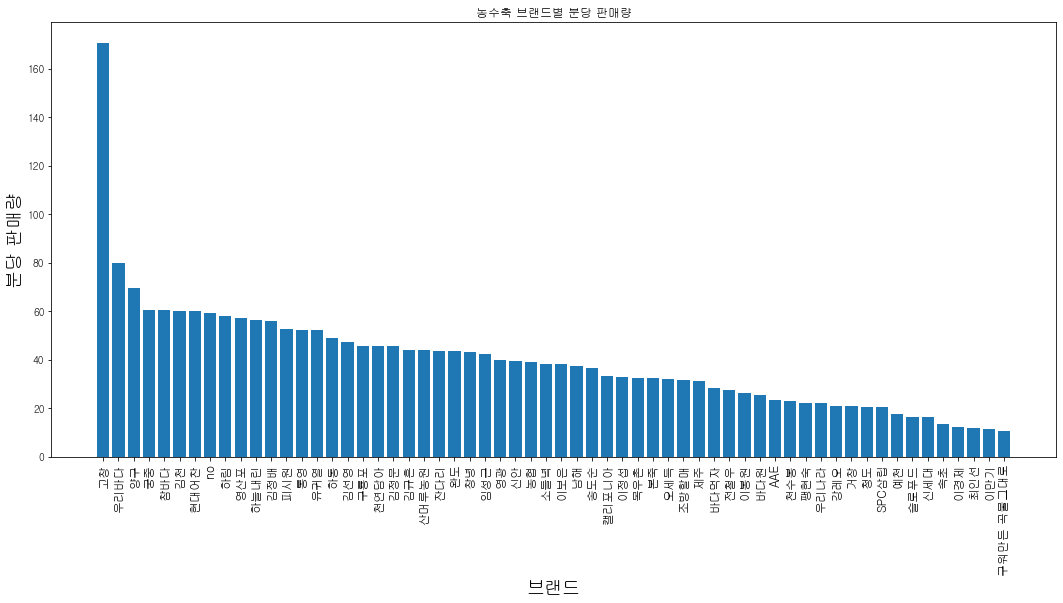

In [15]:
industry_group_df = industry_df['판매량'].groupby(industry_df['brand']).mean().sort_values(ascending=False)

title = '농수축 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(industry_group_df.index), industry_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(industry_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

농수축에서는 **지역** 혹은 **사람** 이름의 상품명을 갖는 경우, 분당 판매량이 높은 것을 알 수 있다.

In [16]:
industry_list = list(industry_group_df[industry_group_df>industry_group_df.quantile(q=0.75, interpolation='nearest')].index) # 상위 25% 이상 브랜드만 선택
print('유의미한 브랜드 수 :', len(industry_list)) # 총 15개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', industry_list) # 총 15개의 브랜드명

유의미한 브랜드 수 : 15
유의미한 브랜드 명 : ['고창', '우리바다', '양구', '궁중', '참바다', '김천', '현대어찬', 'no', '하림', '영산포', '하늘내린', '김정배', '피시원', '통영', '유귀열']


'no' 가 포함되어 있는 것을 확인할 수 있다. 이를 제거해주자

In [17]:
industry_list.remove('no')
print('유의미한 브랜드 수 :', len(industry_list)) # 총 14개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', industry_list) # 'no'를 제외한 총 14개의 브랜드가 선택 됨

유의미한 브랜드 수 : 14
유의미한 브랜드 명 : ['고창', '우리바다', '양구', '궁중', '참바다', '김천', '현대어찬', '하림', '영산포', '하늘내린', '김정배', '피시원', '통영', '유귀열']


### 이미용

In [18]:
beauty = ['비버리힐스폴로클럽', '엘렌실라', '스포메틱스', '스칼프솔루션', '마리끌레르', '파시노', '달바', '마리끌레르', '살롱클리닉',
       '에이유플러스', '라메종', 'TS', '에이온에이', '바바코코', '자올', '엘렌실라', '참존', '라라츄', '엘로엘', '실크테라피',
       '보닌', '시크릿뮤즈', '아미니', '블링썸', '코튼플러스', '엘린실라&코즈미', '네오젠', '뉴웨이', '메디앤서', '아이앤아이',
       '아미니', '미바', '더블모', 'AHC', '컨시크', '고데롤', '피부약방', '클린샤워']

beauty_df = train_raw.loc[train_raw['상품군']=='이미용'].reset_index(drop=True)

for i in tqdm(range(len(beauty_df))):
    for j in beauty:
        if j in beauty_df.loc[i,'상품명']:
            beauty_df.loc[i,'brand'] = j
            
beauty_df['brand'] = beauty_df['brand'].fillna('no')
beauty_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-01 17:00:00,20,100074,200197,비버리힐스폴로클럽 남성기초세트(2018FW골드),이미용,39800,42239000,53.0,비버리힐스폴로클럽
1,2019-01-01 17:20:00,20,100074,200197,비버리힐스폴로클럽 남성기초세트(2018FW골드),이미용,39800,73494000,92.0,비버리힐스폴로클럽
2,2019-01-01 17:40:00,20,100074,200197,비버리힐스폴로클럽 남성기초세트(2018FW골드),이미용,39800,107103000,135.0,비버리힐스폴로클럽
3,2019-01-03 08:00:00,20,100774,202261,엘렌실라 달팽이크림(콜라겐5+팩트3),이미용,79000,13665000,9.0,엘렌실라
4,2019-01-03 08:20:00,20,100774,202261,엘렌실라 달팽이크림(콜라겐5+팩트3),이미용,79000,26788000,17.0,엘렌실라


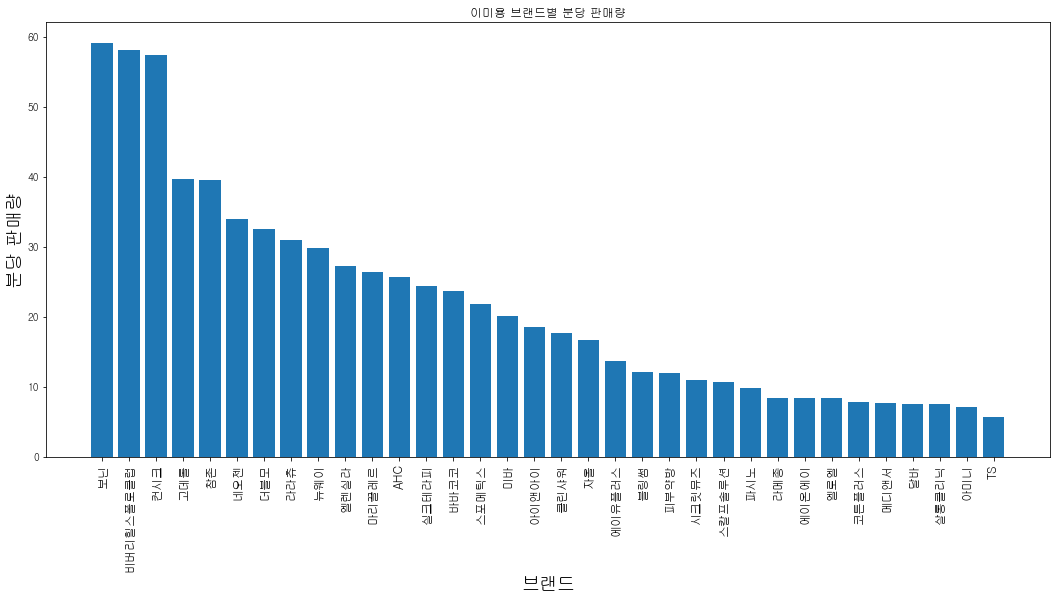

In [19]:
beauty_group_df = beauty_df['판매량'].groupby(beauty_df['brand']).mean().sort_values(ascending=False)

title = '이미용 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(beauty_group_df.index), beauty_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(beauty_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [20]:
beauty_list = list(beauty_group_df[beauty_group_df>beauty_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(beauty_list)) # 총 8의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', beauty_list) # '총 8개의 브랜드 명

유의미한 브랜드 수 : 8
유의미한 브랜드 명 : ['보닌', '비버리힐스폴로클럽', '컨시크', '고데롤', '참존', '네오젠', '더블모', '라라츄']


### 속옷

In [21]:
underwear = ['오모떼', '크로커다일', '푸마', '로베르타', '레이프릴', '쿠미투니카', '에버라스트', '카파', '몬테밀라노', '컬럼비아',
       '남영비비안', '헤스떼벨', '아키', 'BBC&IZUMI', '리복', '오렐리안', '실크트리', '뷰티플렉스', '헤드', '벨레즈온',
       '투홀릭', '댄스킨', '라쉬반', 'LSX라이크라', '오가닉뷰티', '발레리', '란체티', '히트융', '루시헨느', '저스트마이사이즈',
       '코몽트']

underwear_df = train_raw.loc[train_raw['상품군']=='속옷'].reset_index(drop=True)

for i in tqdm(range(len(underwear_df))):
    for j in underwear:
        if j in underwear_df.loc[i,'상품명']:
            underwear_df.loc[i,'brand'] = j
            
underwear_df['brand'] = underwear_df['brand'].fillna('no')
underwear_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-01 07:00:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000,6.0,오모떼
1,2019-01-01 07:20:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000,13.0,오모떼
2,2019-01-01 07:40:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000,22.0,오모떼
3,2019-01-01 11:00:00,20,100664,201999,크로커다일 The 편안한 코튼 브라팬티 4세트,속옷,69900,24531000,18.0,크로커다일
4,2019-01-01 11:20:00,20,100664,201999,크로커다일 The 편안한 코튼 브라팬티 4세트,속옷,69900,49829000,36.0,크로커다일


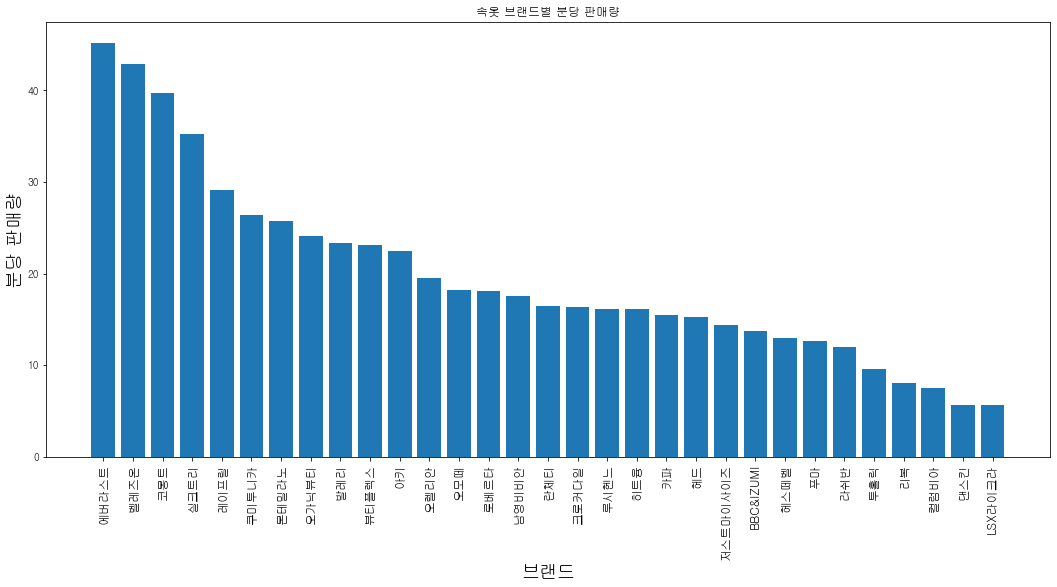

In [22]:
underwear_group_df = underwear_df['판매량'].groupby(underwear_df['brand']).mean().sort_values(ascending=False)

title = '속옷 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(underwear_group_df.index), underwear_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(underwear_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [23]:
underwear_list = list(underwear_group_df[underwear_group_df>underwear_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(underwear_list)) # 총 8개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', underwear_list) # 총 8개의 브랜드명

유의미한 브랜드 수 : 8
유의미한 브랜드 명 : ['에버라스트', '벨레즈온', '코몽트', '실크트리', '레이프릴', '쿠미투니카', '몬테밀라노', '오가닉뷰티']


### 건강기능

In [24]:
health = ['종근당', '제주농장', '베지밀', '한삼인', '황성주', '닥터 슈퍼', '네페르티티', '레모나', '뉴질랜드', '뉴트리원',
       '닥터 프리바이오틱스', '광동', '이경제', '티젠', '모나코사놀', '리얼니파팜', '정직한 농부', '비에날씬', '안국',
       '서울대', '블랙모어스', '전지현']

health_df = train_raw.loc[train_raw['상품군']=='건강기능'].reset_index(drop=True)
for i in tqdm(range(len(health_df))):
    for j in health:
        if j in health_df.loc[i,'상품명']:
            health_df.loc[i,'brand'] = j
            
health_df['brand'] = health_df['brand'].fillna('no')
health_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-02 07:00:00,20,100315,201002,(직매입) 종근당건강 아이클리어 루테인,건강기능,69000,14944000,11.0,종근당
1,2019-01-02 07:20:00,20,100315,201002,(직매입) 종근당건강 아이클리어 루테인,건강기능,69000,25881000,19.0,종근당
2,2019-01-02 07:40:00,20,100315,201002,(직매입) 종근당건강 아이클리어 루테인,건강기능,69000,30126000,22.0,종근당
3,2019-01-03 12:00:00,20,100315,201002,(직매입) 종근당건강 아이클리어 루테인,건강기능,69000,18481000,13.0,종근당
4,2019-01-03 12:20:00,20,100315,201002,(직매입) 종근당건강 아이클리어 루테인,건강기능,69000,24779000,18.0,종근당


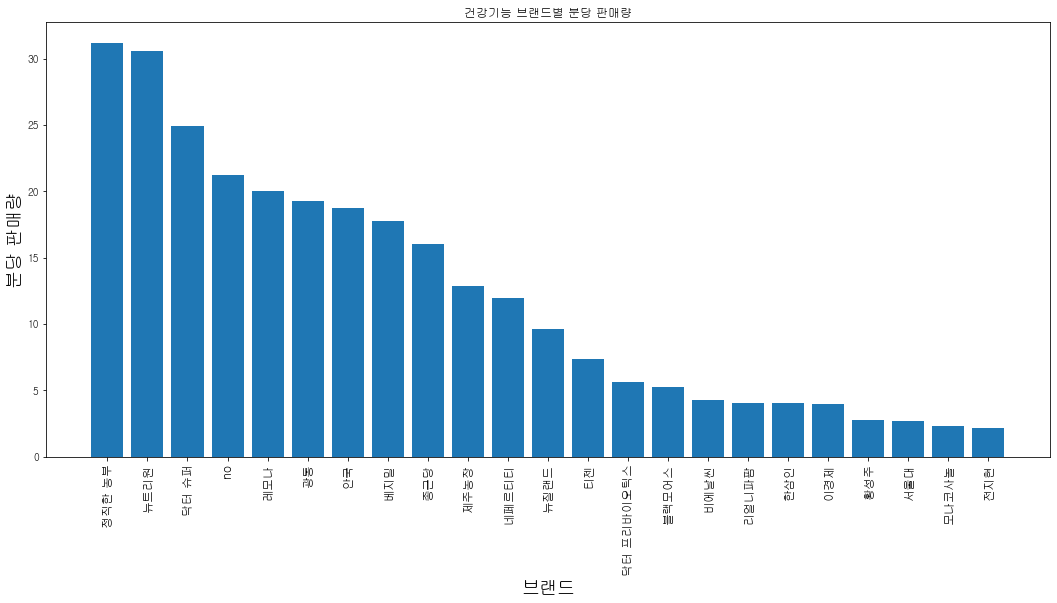

In [25]:
health_group_df = health_df['판매량'].groupby(health_df['brand']).mean().sort_values(ascending=False)

title = '건강기능 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(health_group_df.index), health_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(health_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [26]:
health_list = list(health_group_df[health_group_df>health_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(health_list)) # 총 6개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', health_list) # 총 6개의 브랜드명

유의미한 브랜드 수 : 6
유의미한 브랜드 명 : ['정직한 농부', '뉴트리원', '닥터 슈퍼', 'no', '레모나', '광동']


In [27]:
health_list.remove('no') # 'no' 브랜드 제외
print('유의미한 브랜드 수 :', len(health_list)) # 총 5개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', health_list) # 총 5개의 브랜드명

유의미한 브랜드 수 : 5
유의미한 브랜드 명 : ['정직한 농부', '뉴트리원', '닥터 슈퍼', '레모나', '광동']


### 의류

In [28]:
cloth = ['테이트', 'PAT', '보코', '그렉노먼', '마리노블', '헤스티지', 'NNF', '아문센', '마담팰리스', 'K-SWISS', '아리스토우',
       '도네이', '더블유베일', '로이몬스터', '임페리얼', '메시제이', '크리스티나앤코', '에르나벨', '엔셀라두스', '헤비추얼',
       '뱅뱅', '아주아', '디키즈', '스텔라테일러', 'USPA', '젠트웰', '마르엘라로사티', '오렐리안', '코몽트', '릴리젼',
       '라라쎄', '타운젠트', '코펜하겐럭스', '알렉스하운드', '어반시크릿', '레드캠프', '메이듀', 'EXR', '팜스프링스', '디즈니',
       '대동모피', '이동수골프', '마리노블', '페플럼제이', '유리진', '디베이지', '마모트', '스튜디오럭스', '르까프']

cloth_df = train_raw.loc[train_raw['상품군']=='의류'].reset_index(drop=True)

for i in tqdm(range(len(cloth_df))):
    for j in cloth:
        if j in cloth_df.loc[i,'상품명']:
            cloth_df.loc[i,'brand'] = j
            
cloth_df['brand'] = cloth_df['brand'].fillna('no')
cloth_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,테이트
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,테이트
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,테이트
3,2019-01-01 06:20:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,9.0,테이트
4,2019-01-01 06:40:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,8.0,테이트


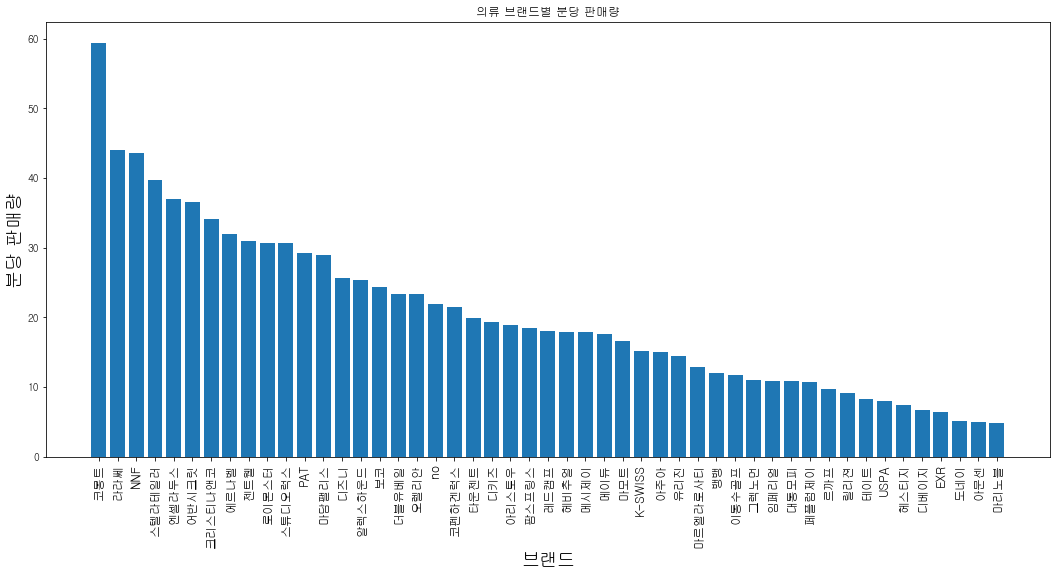

In [29]:
cloth_group_df = cloth_df['판매량'].groupby(cloth_df['brand']).mean().sort_values(ascending=False)

title = '의류 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(cloth_group_df.index), cloth_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(cloth_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [30]:
cloth_list = list(cloth_group_df[cloth_group_df>cloth_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(cloth_list)) # 총 12개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', cloth_list) # 총 12개의 브랜드명

유의미한 브랜드 수 : 12
유의미한 브랜드 명 : ['코몽트', '라라쎄', 'NNF', '스텔라테일러', '엔셀라두스', '어반시크릿', '크리스티나앤코', '에르나벨', '젠트웰', '로이몬스터', '스튜디오럭스', 'PAT']


### 주방

In [31]:
kitchen = ['에코라믹', '쿠첸', '린나이', '키친플라워', '한일', '쿠쿠', '스위스밀리터리', '모즈', '아이오', '락앤락', '에버홈', '올리고',
      '해피콜', '스텐락', '쓰임', '로벤탈', '뉴 클레린', '세균싹', '아이넥스', '프로피쿡', '키친아트', '쿠진나이프케어', '에지리',
      '베스트 하임', '델첸', '올리고', '파뷔에', '드럼쿡', '송도순', '매직쉐프', '테팔', '마리벨', '글라스락', '리큅', '뉴욕맘',
      '한샘', '쿠진', '마이베비', '휴롬', '오스터', '에코바이런', '웰스락 ', '하우홈', 'am마카롱', '두꺼비', '믹서를 품은', '안타고',
      '이지엔', '서장훈', '에델코첸', 'SK매직', '실리만', '노와', 'IH', '벨라홈', '라니 퍼니쿡', 'PN풍년', '비앙코', '센스락', '클란츠',
      '구스터', '실바트', '셰프웨이', '세라맥스', '셀렉프로', '옥샘쿡', '도깨비', '램프쿡']

kitchen_df = train_raw.loc[train_raw['상품군']=='주방'].reset_index(drop=True)

for i in tqdm(range(len(kitchen_df))):
    for j in kitchen:
        if j in kitchen_df.loc[i,'상품명']:
            kitchen_df.loc[i,'brand'] = j
            
kitchen_df['brand'] = kitchen_df['brand'].fillna('no')
kitchen_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-01 12:00:00,20,100088,200236,에코라믹 통주물 스톤 냄비세트,주방,60900,33823000,28.0,에코라믹
1,2019-01-01 12:20:00,20,100088,200236,에코라믹 통주물 스톤 냄비세트,주방,60900,59083000,49.0,에코라믹
2,2019-01-01 12:40:00,20,100088,200236,에코라믹 통주물 스톤 냄비세트,주방,60900,99235000,81.0,에코라믹
3,2019-01-02 10:00:00,20,100448,202098,일시불 쿠첸 풀스텐 압력밥솥 10인용 (A1),주방,158000,7239000,2.0,쿠첸
4,2019-01-02 10:00:00,20,100448,202093,무이자 쿠첸 풀스텐 압력밥솥 10인용(A1),주방,168000,8951000,3.0,쿠첸


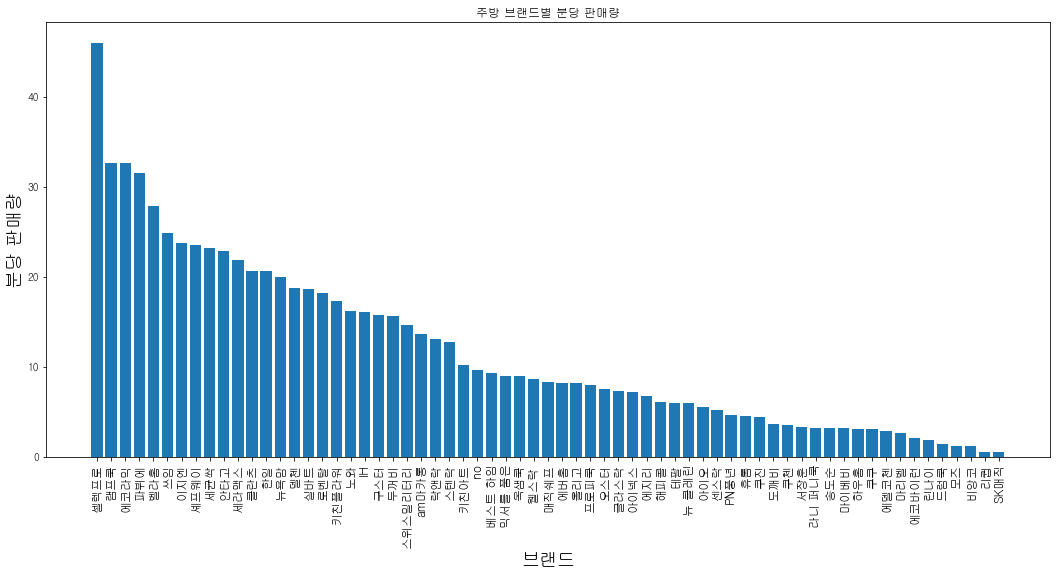

In [32]:
kitchen_group_df = kitchen_df['판매량'].groupby(kitchen_df['brand']).mean().sort_values(ascending=False)

title = '주방 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(kitchen_group_df.index), kitchen_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(kitchen_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')    
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [33]:
kitchen_list = list(kitchen_group_df[kitchen_group_df>kitchen_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(kitchen_list)) # 총 12개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', kitchen_list) # 총 12개의 브랜드명

유의미한 브랜드 수 : 16
유의미한 브랜드 명 : ['셀렉프로', '램프쿡', '에코라믹', '파뷔에', '벨라홈', '쓰임', '이지엔', '셰프웨이', '세균싹', '안타고', '세라맥스', '클란츠', '한일', '뉴욕맘', '델첸', '실바트']


### 잡화

In [34]:
item = ['에펨', '로베르타', '가이거', '세인트스코트', '도스문도스', '마스케라', '엘르 메르시', '월드컵', '칼리베이직', '아가타',
       '엘리자베스아덴', '삭루츠', '스프리스', '플로쥬', '제옥스', '레코바', '트레스패스', '안드레아바나', '썸덱스', 'DIOR',
       '프라다', '기라로쉬', '코치', '메이듀', '시스마르스', '오델로', 'AAD', '레노마', '루이띠에', '생즐랑', '골드파일', '알비에로 마르티니',
       '바치', '구찌', '에트로', '갈란테', 'RYN', '메디아글램', '에버라스트', 'AAA', '아르테사노', '버버리', '마이클코어스']

item_df = train_raw.loc[train_raw['상품군']=='잡화'].reset_index(drop=True)

for i in tqdm(range(len(item_df))):
    for j in item:
        if j in item_df.loc[i,'상품명']:
            item_df.loc[i,'brand'] = j
            
item_df['brand'] = item_df['brand'].fillna('no')
item_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-03 06:00:00,20,100781,202292,에펨 여성 미들퍼부츠,잡화,39800,2450000,3.0,에펨
1,2019-01-03 06:00:00,20,100781,202285,에펨 남성 미들퍼부츠,잡화,49800,2645000,3.0,에펨
2,2019-01-03 06:20:00,20,100781,202292,에펨 여성 미들퍼부츠,잡화,39800,5609000,7.0,에펨
3,2019-01-03 06:20:00,20,100781,202285,에펨 남성 미들퍼부츠,잡화,49800,3874000,4.0,에펨
4,2019-01-03 06:40:00,20,100781,202292,에펨 여성 미들퍼부츠,잡화,39800,9045000,11.0,에펨


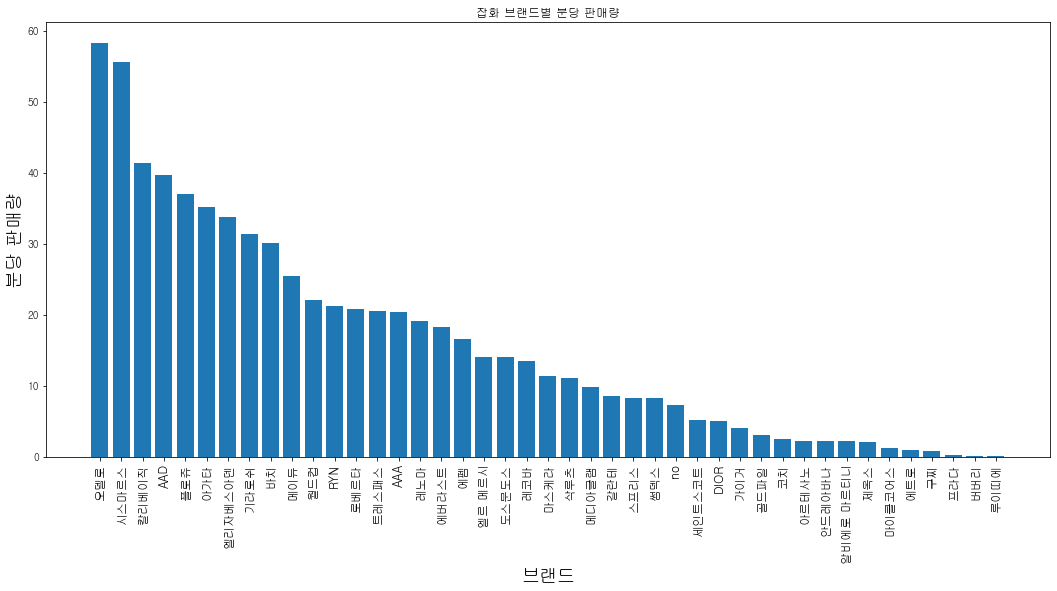

In [35]:
item_group_df = item_df['판매량'].groupby(item_df['brand']).mean().sort_values(ascending=False)

title = '잡화 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(item_group_df.index), item_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(item_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [36]:
item_list = list(item_group_df[item_group_df>item_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(item_list)) # 총 12개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', item_list) # 총 12개의 브랜드명

유의미한 브랜드 수 : 10
유의미한 브랜드 명 : ['오델로', '시스마르스', '칼리베이직', 'AAD', '플로쥬', '아가타', '엘리자베스아덴', '기라로쉬', '바치', '메이듀']


### 가전

In [37]:
appliance = ['삼성','LG','대우전자','캐리어']

appliance_df = train_raw.loc[train_raw['상품군']=='가전'].reset_index(drop=True)
for i in tqdm(range(len(appliance_df))):
    for j in appliance:
        if j in appliance_df.loc[i,'상품명']:
            appliance_df.loc[i,'brand'] = j
            
appliance_df['brand'] = appliance_df['brand'].fillna('no')
appliance_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-01 20:00:00,20,100150,200533,일시불 LG 통돌이 세탁기,가전,439000,35519000,4.0,LG
1,2019-01-01 20:00:00,20,100150,200465,무이자 LG 통돌이 세탁기,가전,489000,19123000,2.0,LG
2,2019-01-01 20:20:00,20,100150,200533,일시불 LG 통돌이 세탁기,가전,439000,56859000,6.0,LG
3,2019-01-01 20:20:00,20,100150,200465,무이자 LG 통돌이 세탁기,가전,489000,58685000,6.0,LG
4,2019-01-01 20:40:00,20,100150,200533,일시불 LG 통돌이 세탁기,가전,439000,68320000,8.0,LG


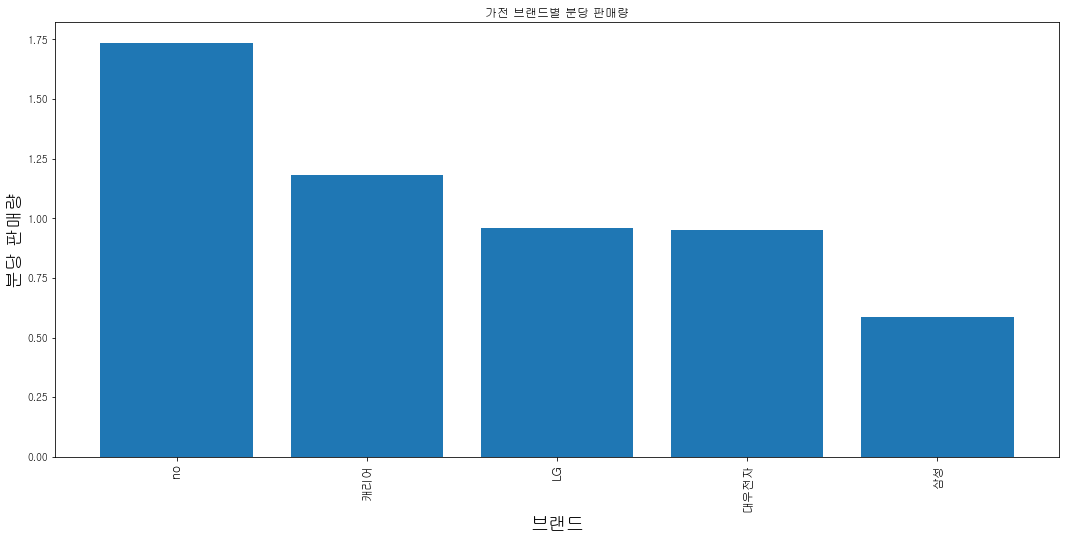

In [38]:
appliance_group_df = appliance_df['판매량'].groupby(appliance_df['brand']).mean().sort_values(ascending=False)

title = '가전 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(appliance_group_df.index), appliance_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(appliance_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

가전의 경우 주요 브랜드 사이에서 유의미한 차이가 존재하지 않는다.

오히려 브랜드 아닌 경우가 분당 판매량이 가장 높았다.

In [39]:
appliance_list = list(appliance_group_df[appliance_group_df>appliance_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(appliance_list)) # 선택된 브랜드 없음
print('유의미한 브랜드 명 :', appliance_list)

유의미한 브랜드 수 : 1
유의미한 브랜드 명 : ['no']


In [40]:
appliance_list.remove('no')
print('유의미한 브랜드 수 :', len(appliance_list)) 
print('유의미한 브랜드 명 :', appliance_list)

유의미한 브랜드 수 : 0
유의미한 브랜드 명 : []


### 가구

In [41]:
furniture = ['보루네오', '삼익가구', '한샘', '장수', '이누스바스', '삼익가구', '벨라홈', '이조농방', '레스토닉', '유캐슬']

furniture_df = train_raw.loc[train_raw['상품군']=='가구'].reset_index(drop=True)
for i in tqdm(range(len(furniture_df))):
    for j in furniture:
        if j in furniture_df.loc[i,'상품명']:
            furniture_df.loc[i,'brand'] = j

furniture_df['brand'] = furniture_df['brand'].fillna('no')
furniture_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-02-01 22:00:00,20,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,7399000,1.0,보루네오
1,2019-02-01 22:00:00,20,100205,200732,보루네오 루나 유로탑 멀티수납형 LED 침대 Q 퀸,가구,598000,3264000,0.0,보루네오
2,2019-02-01 22:00:00,20,100205,200731,보루네오 루나 유로탑 멀티수납형 LED 침대 K 킹,가구,648000,5271000,0.0,보루네오
3,2019-02-01 22:20:00,20,100205,200733,보루네오 루나 유로탑 멀티수납형 LED 침대 SS 슈퍼싱글,가구,548000,20638000,2.0,보루네오
4,2019-02-01 22:20:00,20,100205,200732,보루네오 루나 유로탑 멀티수납형 LED 침대 Q 퀸,가구,598000,17701000,1.0,보루네오


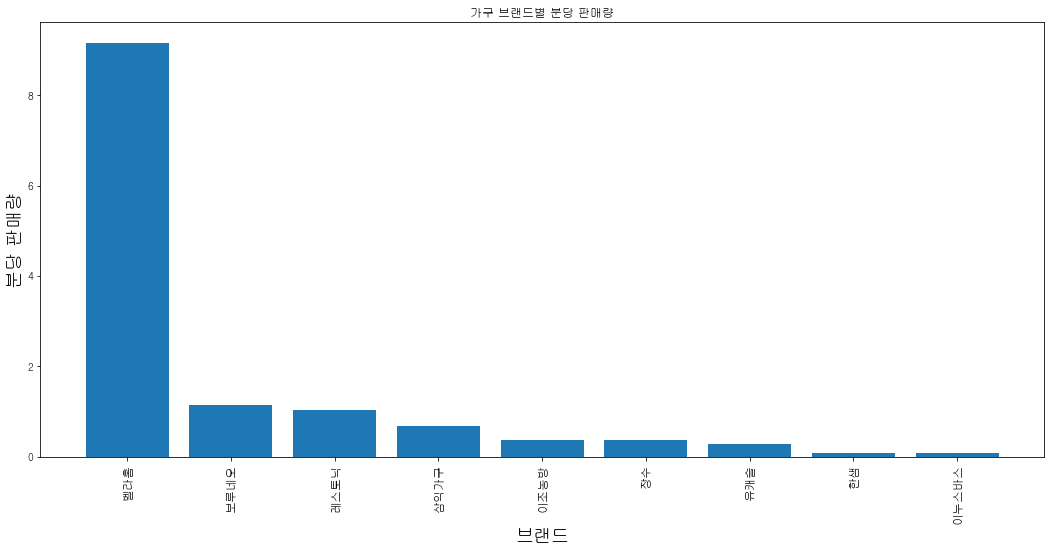

In [42]:
furniture_group_df = furniture_df['판매량'].groupby(furniture_df['brand']).mean().sort_values(ascending=False)

title = '가구 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(furniture_group_df.index), furniture_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(furniture_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [43]:
furniture_list = list(furniture_group_df[furniture_group_df>furniture_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(furniture_list)) # 총 2개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', furniture_list) # 총 2개의 브랜드명

유의미한 브랜드 수 : 2
유의미한 브랜드 명 : ['벨라홈', '보루네오']


### 침구

In [44]:
bed = ['보몽드', '한샘', '리앤코리아', '효재', '안지', '한빛', '리앤']

bed_df = train_raw.loc[train_raw['상품군']=='침구'].reset_index(drop=True)
for i in tqdm(range(len(bed_df))):
    for j in bed:
        if j in bed_df.loc[i,'상품명']:
            bed_df.loc[i,'brand'] = j
            
bed_df['brand'] = bed_df['brand'].fillna('no')
bed_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-04-18 12:00:00,20,100140,200377,보몽드 순면60수 피그먼트워싱 침구세트 SS,침구,59900,6400000,5.0,보몽드
1,2019-04-18 12:00:00,20,100140,200376,보몽드 순면60수 피그먼트워싱 침구세트 Q,침구,69900,6334000,5.0,보몽드
2,2019-04-18 12:00:00,20,100140,200375,보몽드 순면60수 피그먼트워싱 침구세트 K,침구,79900,7421000,5.0,보몽드
3,2019-04-18 12:20:00,20,100140,200377,보몽드 순면60수 피그먼트워싱 침구세트 SS,침구,59900,6825000,6.0,보몽드
4,2019-04-18 12:20:00,20,100140,200376,보몽드 순면60수 피그먼트워싱 침구세트 Q,침구,69900,7182000,5.0,보몽드


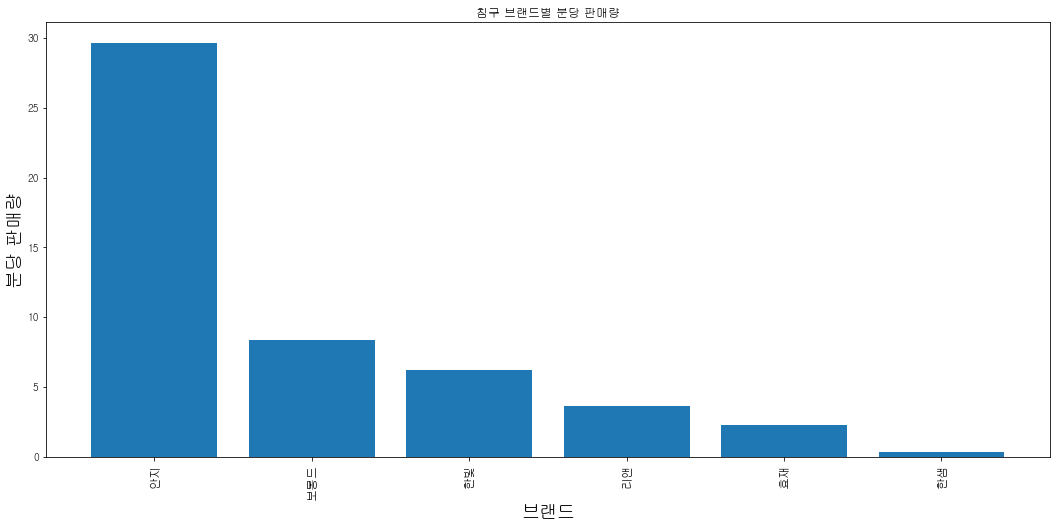

In [45]:
bed_group_df = bed_df['판매량'].groupby(bed_df['brand']).mean().sort_values(ascending=False)

title = '침구 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(bed_group_df.index), bed_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(bed_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [46]:
bed_list = list(bed_group_df[bed_group_df>bed_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(bed_list)) # 총 1개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', bed_list) # 총 1개의 브랜드명

유의미한 브랜드 수 : 1
유의미한 브랜드 명 : ['안지']


### 생활용품

In [47]:
life = ['벨라홈', '노비타', '코이모', '스위스밀리터리', '메디실드', '씨엔지코리아',
       '크린조이', '세렌셉템버', '까사마루', '바로바로', '올바로', '선일금고', '김병만',
       '코튼데이', '굿프렌드', '숀리', '스피드랙', 'LG생활건강', '메디컬드림', '모리츠',
       '거미소', '한일', '바로톡', '디비노', '대웅모닝컴', '이지스', '뚜러킹', '자미코코',
       '타이거', '도루코', '노송가구', '코지마', '퀸메이드', '블루콤', '브람스', '파워스윙',
       '캐치온', '니봇', '중외신약', '킹스스파', '얼리젼', '밀레', '스팀큐', '바두기', '김병지',
       '일월', '트라이 브라이트', '페르소나', '발렌티노루디', '레스트업', '센티멘탈', '센스톰',
       '한솔', '파로마', '보국', '따스림', '테팔', 'OK', '루미테라피', '엑사이더', '월시스',
       '스칸디나비아', '히팅맘', '센스하우스', '사운드룩', '수련', '엔웰스', '밸런스파워']

life_df = train_raw.loc[train_raw['상품군']=='생활용품'].reset_index(drop=True)
for i in tqdm(range(len(life_df))):
    for j in life:
        if j in life_df.loc[i,'상품명']:
            life_df.loc[i,'brand'] = j
            
life_df['brand'] = life_df['brand'].fillna('no')
life_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand
0,2019-01-02 06:00:00,20,100229,200800,벨라홈 논슬립 옷걸이 세트,생활용품,29800,9605000,16.0,벨라홈
1,2019-01-02 06:20:00,20,100229,200800,벨라홈 논슬립 옷걸이 세트,생활용품,29800,11265000,19.0,벨라홈
2,2019-01-02 06:40:00,20,100229,200800,벨라홈 논슬립 옷걸이 세트,생활용품,29800,14371000,24.0,벨라홈
3,2019-01-03 20:00:00,20,100501,201514,노비타 스마트 비데,생활용품,189000,41183000,11.0,노비타
4,2019-01-03 20:20:00,20,100501,201514,노비타 스마트 비데,생활용품,189000,83995000,22.0,노비타


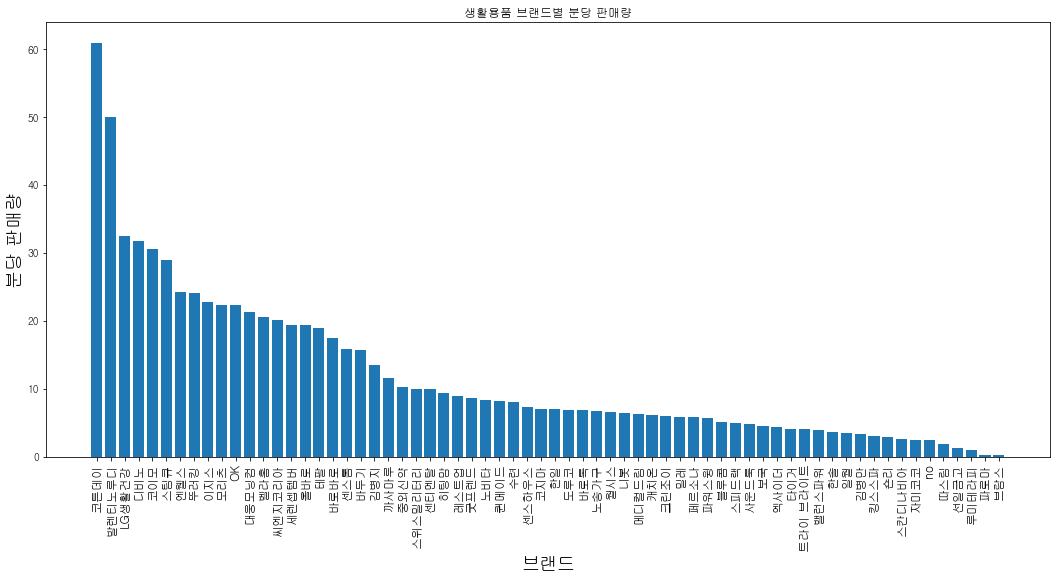

In [48]:
life_group_df = life_df['판매량'].groupby(life_df['brand']).mean().sort_values(ascending=False)

title = '생활용품 브랜드별 분당 판매량'
fig, ax = plt.subplots(figsize = (18, 8))
ax.bar(list(life_group_df.index), life_group_df)
ax.set_xlabel('브랜드', fontsize = 18)
ax.set_ylabel('분당 판매량', fontsize = 18)
ax.set_xticklabels(list(life_group_df.index), fontsize = 12, rotation = 90)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

특정 브랜드 상품에 대한 분당 판매량의 차이가 유의미 함을 알 수 있다.

In [49]:
life_list = list(life_group_df[life_group_df>life_group_df.quantile(q=0.75, interpolation='nearest')].index)
print('유의미한 브랜드 수 :', len(life_list)) # 총 16개의 브랜드가 선택 됨
print('유의미한 브랜드 명 :', life_list) # 총 16개의 브랜드명

유의미한 브랜드 수 : 16
유의미한 브랜드 명 : ['코튼데이', '발렌티노루디', 'LG생활건강', '디비노', '코이모', '스팀큐', '엔웰스', '뚜러킹', '이지스', '모리츠', 'OK', '대웅모닝컴', '벨라홈', '씨엔지코리아', '세렌셉템버', '올바로']


각 상품군별 상위 25% 분당 평균 판매량을 가지는 브랜드를 브랜드 파워가 존재한다고 판단하였음   

그렇게 설정한 이유는 각 상품군별 유의미한 차이의 범위 값이 모두 다르고, 공평하게 분위수를 적용하여 '브랜드 파워' 변수를 만들고 싶었음

In [50]:
# 최종 브랜드 선정
brand_list = list(set(industry_list + beauty_list + underwear_list + health_list + cloth_list + kitchen_list + item_list + appliance_list + furniture_list + bed_list + life_list))
print('최종 브랜드 목록 갯수 : ', len(brand_list)) # 89개
print('최종 브랜드 목록 : ', brand_list) 

최종 브랜드 목록 갯수 :  89
최종 브랜드 목록 :  ['코튼데이', '이지엔', '실크트리', '레이프릴', '엘리자베스아덴', '스텔라테일러', '몬테밀라노', '유귀열', '참바다', '램프쿡', '레모나', '실바트', 'PAT', '에버라스트', '칼리베이직', '안지', '고데롤', '플로쥬', '우리바다', '스팀큐', '기라로쉬', 'AAD', '로이몬스터', '델첸', '모리츠', '코이모', 'NNF', '안타고', '한일', '보루네오', '세렌셉템버', '크리스티나앤코', '라라츄', '김정배', '영산포', '고창', '젠트웰', '양구', '세균싹', '시스마르스', '벨레즈온', '스튜디오럭스', '어반시크릿', '뚜러킹', '바치', '에르나벨', '쓰임', '이지스', '씨엔지코리아', '피시원', '닥터 슈퍼', '쿠미투니카', '통영', '현대어찬', '네오젠', '컨시크', '뉴트리원', '더블모', '오델로', '셰프웨이', '발렌티노루디', '세라맥스', '정직한 농부', '에코라믹', '궁중', 'LG생활건강', '디비노', '코몽트', '보닌', 'OK', '아가타', '파뷔에', '라라쎄', '벨라홈', '참존', '대웅모닝컴', '셀렉프로', '비버리힐스폴로클럽', '하림', '올바로', '클란츠', '엔셀라두스', '오가닉뷰티', '엔웰스', '뉴욕맘', '하늘내린', '메이듀', '광동', '김천']


**브랜드 파워** 변수 생성

In [51]:
# Train 데이터에 '브랜드 파워' 변수 생성
train_raw['brand'] = 0.0 # 브랜드 파워 존재 X

for i in tqdm(range(len(train_raw))):
    for j in brand_list:
        if j in train_raw.loc[i,'상품명']:
            train_raw.loc[i,'brand'] = 1.0 # 브랜드 파워 존재

In [52]:
# Test 데이터에 '브랜드 파워' 변수 생성

test_raw['brand'] = 0.0 # 브랜드 파워 존재 X

for i in tqdm(range(len(test_raw))):
    for j in brand_list:
        if j in test_raw.loc[i,'상품명']:
            test_raw.loc[i,'brand'] = 1.0 # 브랜드 파워 존재

In [53]:
print('Brand 변수 생성한 이후 Train 데이터 형태 : ', train_raw.shape)
print('Brand 변수 생성한 이후 test 데이터 형태 : ', test_raw.shape)

Brand 변수 생성한 이후 Train 데이터 형태 :  (35379, 10)
Brand 변수 생성한 이후 test 데이터 형태 :  (2716, 10)


## 시간

### 주중/주말 비교

In [54]:
# Train weekday 변수 생성

for i in tqdm(range(len(train_raw))):
    if pd.isna(train_raw.loc[i,'노출(분)']):
        train_raw.loc[i,'노출(분)'] = train_raw.loc[(i-1),'노출(분)']
        
train_raw['date'] = train_raw['방송일시'].apply(lambda x:x.strftime('%Y-%m-%d'))
train_raw['hour'] = train_raw['방송일시'].apply(lambda x:x.strftime('%H'))
train_raw['weekday'] = train_raw['방송일시'].apply(lambda x:x.strftime('%w'))
train_raw['month'] = train_raw['방송일시'].apply(lambda x:x.strftime('%m'))

for i in tqdm(range(len(train_raw))):
    if train_raw.loc[i,'weekday'] in ['0','6']:
        train_raw.loc[i,'weekday'] = 1.0
    else:
        train_raw.loc[i,'weekday'] = 0.0

#### 막대 그래프를 통한 변수의 유의성 시각화

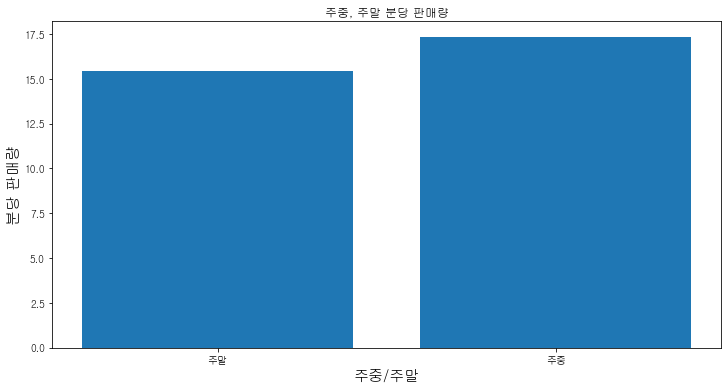

In [55]:
week_group_df = train_raw['판매량'].groupby(train_raw['weekday']).mean().sort_values(ascending=False)

title = '주중, 주말 분당 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(week_group_df.index), week_group_df)
ax.set_xlabel('주중/주말', fontsize = 15)
ax.set_ylabel('분당 판매량', fontsize = 15)
ax.set_xticks([0,1])
ax.set_xticklabels(['주말', '주중'], fontsize = 10)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

주중, 주말의 분당 판매량에는 차이가 있음을 알 수 있다.   

주말의 경우, 판매량이 더 높았음을 알 수 있다.

#### T-Test

독립표본 t-검정을 통해 주말/주중의 분당 판매량 평균을 비교해보자.   

H0(귀무가설) : 주중과 주말의 분당 평균 판매량은 같다.   

H1(귀무가설) : 주중과 주말의 분당 평균 판매량은 다르다.

In [56]:
group_weekday = train_raw.loc[train_raw['weekday'] == 1] # 주말
group_weekend = train_raw.loc[train_raw['weekday'] == 0] # 주중

print('주말 데이터 형태 : ', group_weekday.shape)
print('평일 데이터 형태 : ', group_weekend.shape)

주말 데이터 형태 :  (10060, 14)
평일 데이터 형태 :  (25319, 14)


Levene 등분산 검정 시행을 함 (등분산과 이분산인 경우 서로 검정 결과가 달라지기 때문)   

H0(귀무가설) : 두 그룹의 분산은 같다.   

H1(대립가설) : 두 그룹의 분산은 다르다.

In [57]:
lresult = stats.levene(group_weekday['판매량'], group_weekend['판매량'])
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult))

LeveneResult(F) : 96.281 
p-value : 0.000


P-value = 0.000으로 0.05보다 작으므로 귀무가설을 기각한다.   

즉, 두 그룹의 분산은 다르다.   

등분산이 아닌 경우 독립표본 t-검정을 통해 두 그룹의 평균 유의미한 차이를 확인해보자.

In [58]:
#등분산이 아닌 독립표본 t-검정 실행 
t_result = stats.ttest_ind(group_weekday['판매량'], group_weekend['판매량'], equal_var=False) 
print('t statistic : %.3f \np-value : %.3f' % (t_result))

t statistic : 6.611 
p-value : 0.000


p-value = 0.000으로 0.05보다 작으므로 귀무가설을 기각한다.   

즉, 주말과 주중의 분당 평균 판매량은 다르다고 말 할 수 있다.

In [59]:
# Test 데이터에 'Weekday' 변수 생성

for i in tqdm(range(len(test_raw))):
    if pd.isna(test_raw.loc[i,'노출(분)']):
        test_raw.loc[i,'노출(분)'] = test_raw.loc[(i-1),'노출(분)']
        
test_raw['date'] = test_raw['방송일시'].apply(lambda x:x.strftime('%Y-%m-%d'))
test_raw['hour'] = test_raw['방송일시'].apply(lambda x:x.strftime('%H'))
test_raw['weekday'] = test_raw['방송일시'].apply(lambda x:x.strftime('%w'))
test_raw['month'] = test_raw['방송일시'].apply(lambda x:x.strftime('%m'))

for i in tqdm(range(len(test_raw))):
    if test_raw.loc[i,'weekday'] in ['0','6']:
        test_raw.loc[i,'weekday'] = 1.0
    else:
        test_raw.loc[i,'weekday'] = 0.0

### 월 초/중/말

- 1~10 일은 월 초   

- 11~20 일은 월 중   

- 21 ~ 일은 월 말

In [60]:
print('변수 추가되기 이전의 데이터 형태 : ', train_raw.shape)
train_raw['초중말']=pd.Series()
train_raw['day'] = train_raw['방송일시'].apply(lambda x:x.strftime('%d'))
train_raw['day']=train_raw['day'].astype('int')

for i in tqdm(range(len(train_raw))):
    if train_raw.loc[i,'day'] <=10:
        train_raw.loc[i,'초중말']=0  #월 초
    elif train_raw.loc[i,'day']<=20:
        train_raw.loc[i,'초중말']=1  #월 중
    else:
        train_raw.loc[i,'초중말']=2  #월 말

train_raw['day'] = train_raw['day'].astype('object')        
train_raw['초중말'] = train_raw['초중말'].astype('object')

print('변수 추가되기 이후의 데이터 형태 : ', train_raw.shape)

변수 추가되기 이전의 데이터 형태 :  (35379, 14)



변수 추가되기 이후의 데이터 형태 :  (35379, 16)


#### 막대 그래프를 통한 변수의 유의성 시각화

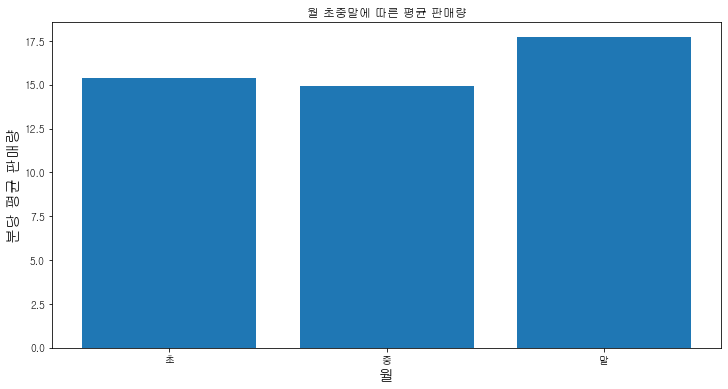

In [61]:
month_group_df=train_raw['판매량'].groupby(train_raw['초중말']).mean()

title = '월 초중말에 따른 평균 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(month_group_df.index, month_group_df)
ax.set_xlabel('월', fontsize = 15)
ax.set_xticks(np.arange(len(month_group_df.index)))
ax.set_ylabel('분당 평균 판매량', fontsize = 15)
ax.set_xticklabels(['초', '중', '말'])
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

위의 그림을 통해, 월초 ~ 월말 사이의 평균 분당 판매량에서 유의한 차이가 있었음을 알 수 있다.

특히, 월말의 분당 판매량이 가장 높았음을 알 수 있다.

In [62]:
print('변수 추가되기 이전의 데이터 형태 : ', test_raw.shape)
test_raw['초중말']=pd.Series()
test_raw['day'] = test_raw['방송일시'].apply(lambda x:x.strftime('%d'))
test_raw['day']=test_raw['day'].astype('int')

for i in tqdm(range(len(test_raw))):
    if test_raw.loc[i,'day'] <=10:
        test_raw.loc[i,'초중말']=0  #월 초
    elif test_raw.loc[i,'day']<=20:
        test_raw.loc[i,'초중말']=1  #월 중
    else:
        test_raw.loc[i,'초중말']=2  #월 말
        
test_raw['day']=test_raw['day'].astype('object')        
test_raw['초중말']=test_raw['초중말'].astype('object')

print('변수 추가되기 이후의 데이터 형태 : ', test_raw.shape)

변수 추가되기 이전의 데이터 형태 :  (2716, 14)



변수 추가되기 이후의 데이터 형태 :  (2716, 16)


### 프라임 타임

프라임 타임이란, 하루 중 프로그램 시청률이 가장 높은 시간대를 의미한다.   

기존 NS홈쇼핑의 프라임 타임은 오전 9-11시, 오후 4-6시이다.  
하지만, 2019년 데이터를 보면 카테고리 별 시간대 시청률 순위가 다른 것을 볼 수 있다.   

시청률 분석을 통해 프라임타임을 재조정하기로 하여 분석에 사용해보자.

In [63]:
view_raw = pd.read_excel('./Data/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx')
view_raw = view_raw.rename(columns=view_raw.iloc[0])[1:].reset_index(drop=True)
view_raw = view_raw.loc[0:1439,]
view_raw['time'] = pd.to_datetime(view_raw['시간대'], format='%H:%M', errors='raise')
view_raw['time'] = view_raw['time'].apply(lambda dt: dt.replace(year=2019))
view_raw['hour'] = view_raw['time'].apply(lambda x:x.strftime('%H'))
view_mean_df = view_raw.drop(['2019-01-01 to 2019-12-31','time','시간대'],axis=1).groupby('hour').sum()/60 # 해당 날짜의 시간별 평균 시청률
view_raw.head()

,시간대,2019-01-01,2019-01-02,2019-01-03,2019-01-04,2019-01-05,2019-01-06,2019-01-07,2019-01-08,2019-01-09,...,2019-12-25,2019-12-26,2019-12-27,2019-12-28,2019-12-29,2019-12-30,2019-12-31,2019-01-01 to 2019-12-31,time,hour
0,02:00,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.003,2019-01-01 02:00:00,02
1,02:01,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0.012,0.003,2019-01-01 02:01:00,02
2,02:02,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0.004,2019-01-01 02:02:00,02
3,02:03,0,0,0.014,0,0,0,0,0,0,...,0.017,0,0,0,0,0,0,0.004,2019-01-01 02:03:00,02
4,02:04,0,0,0,0,0,0,0,0,0,...,0.017,0,0,0,0,0,0,0.004,2019-01-01 02:04:00,02


In [64]:
list_view = list(view_mean_df.columns) # 2019-01-01 ~ 2019-12-31

final_clust_df = pd.DataFrame()

for i in tqdm(range(len(list_view))):
    temp1 = train_raw.loc[train_raw['date']==list_view[i]]
    temp2 = view_mean_df[list_view[i]]
    temp1 = pd.merge(temp1,temp2,how='left',on='hour')
    temp1.columns = ['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액','판매량','brand','date',
           'hour', 'weekday', 'month', '초중말', 'day', '시청률']
    final_clust_df = pd.concat([final_clust_df,temp1],axis=0).reset_index(drop=True)
final_clust_df.head(3)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand,date,hour,weekday,month,초중말,day,시청률
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,0.0,2019-01-01,06,0,01,0,1,0.0
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,0.0,2019-01-01,06,0,01,0,1,0.0
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,0.0,2019-01-01,06,0,01,0,1,0.0


상품군별 상위 3개의 시간을 프라임타임으로 정하고 이를 추출하자

In [65]:
prime_temp = final_clust_df[['상품군','hour','시청률','weekday']]
group_list = list(prime_temp['상품군'].unique())
week_end_dict = dict() # 주말
week_day_dict = dict() # 주중
for i in tqdm(group_list):
    week_end_dict[i]=list(prime_temp.loc[(prime_temp['상품군']==i)&(prime_temp['weekday']==1),'시청률'].groupby(prime_temp['hour']).mean().sort_values(ascending=False)[:3].index)
    week_day_dict[i]=list(prime_temp.loc[(prime_temp['상품군']==i)&(prime_temp['weekday']==0),'시청률'].groupby(prime_temp['hour']).mean().sort_values(ascending=False)[:3].index)   

In [66]:
print('주말 상위 시청률 3시간 : ', week_day_dict)
print('-'*50)
print('주중 상위 시청률 3시간 : ', week_end_dict)

주말 상위 시청률 3시간 :  {'의류': ['18', '02', '10'], '속옷': ['13', '02', '14'], '주방': ['14', '23', '17'], '농수축': ['00', '11', '01'], '이미용': ['15', '10', '00'], '가전': ['14', '15', '16'], '생활용품': ['23', '22', '16'], '건강기능': ['11', '00', '14'], '잡화': ['16', '10', '02'], '가구': ['10', '01', '19'], '침구': ['22', '23', '01']}
--------------------------------------------------
주중 상위 시청률 3시간 :  {'의류': ['17', '18', '14'], '속옷': ['17', '14', '10'], '주방': ['23', '06', '15'], '농수축': ['23', '15', '10'], '이미용': ['18', '23', '11'], '가전': ['00', '07', '15'], '생활용품': ['16', '08', '17'], '건강기능': ['14', '17', '22'], '잡화': ['14', '15', '11'], '가구': ['06', '07', '08'], '침구': ['13', '12', '21']}


**프라임 타임** 변수 생성

In [67]:
# Train 에서 Prime 변수 생성

train_raw['prime'] = pd.Series()

for i in tqdm(range(len(train_raw))):
    group = train_raw.loc[i,'상품군']
    if train_raw.loc[i,'weekday']==1.0: # 주말인 경우 상품군 별 해당 시간대의 프라임 타임 생성
        if train_raw.loc[i,'hour'] in week_end_dict[group]:
            train_raw.loc[i,'prime'] = 1.0 # 프라임 타임
        else:
            train_raw.loc[i,'prime'] = 0.0 # 비 프라임 타임
    else: # 평일인 경우 상품군 별 해당 시간대의 프라임 타임 생성
        if train_raw.loc[i,'hour'] in week_day_dict[group]:
            train_raw.loc[i,'prime'] = 1.0
        else:
            train_raw.loc[i,'prime'] = 0.0

#### 막대 그래프를 통한 변수의 유의성 시각화

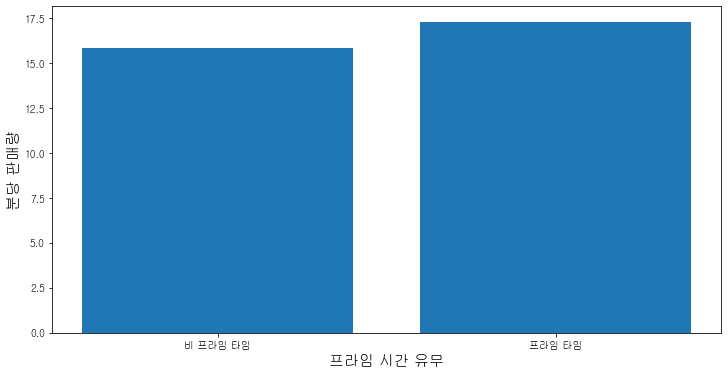

In [68]:
# 프라임 타임 유무에 따른 분당 판매량
prime_group_df = train_raw['판매량'].groupby(train_raw['prime']).mean().sort_values(ascending=False)

title = '프라임 시간 유무에 따른 분당 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(prime_group_df.index), prime_group_df)
ax.set_xlabel('프라임 시간 유무', fontsize = 15)
ax.set_xticks([0, 1])
ax.set_ylabel('분당 판매량', fontsize = 15)
ax.set_xticklabels(['비 프라임 타임', '프라임 타임'], fontsize = 10)
plt.savefig(f'./graphs/{title}.png')
plt.show()

프라임 타임, 비 프라임 타임의 분당 판매량에는 차이가 있음을 알 수 있다.   

프라임 타임의 경우, 판매량이 더 높았음을 알 수 있다.

#### T-Test

- H0 : 프라임 타임 여부에 따른 평균 판매량은 차이가 없다.
- H1 : 프라임 타임 여부에 따른 평균 판매량은 차이가 있다.

In [69]:
group_prime = train_raw.loc[train_raw['weekday'] == 1] # 주말
group_notprime = train_raw.loc[train_raw['weekday'] == 0] # 주중

print('프라임 타임 데이터 형태 : ', group_prime.shape)
print('비 프라임 타임 데이터 형태 : ', group_notprime.shape)

프라임 타임 데이터 형태 :  (10060, 17)
비 프라임 타임 데이터 형태 :  (25319, 17)


In [70]:
# levene 등분산 검정
lresult = stats.levene(group_prime['판매량'], group_notprime['판매량'])
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult)) # p-value : 0.000 으로 이분산성

LeveneResult(F) : 96.281 
p-value : 0.000


In [71]:
# 등분산이 아닌 독립표본 t-검정 실행 
t_result = stats.ttest_ind(group_weekday['판매량'], group_weekend['판매량'], equal_var=False) 
print('t statistic : %.3f \np-value : %.3f' % (t_result))

t statistic : 6.611 
p-value : 0.000


p-value 0.000으로 0.05보다 작으므로 귀무가설을 기각한다.   

즉, 프라임 타임과 비 프라임 타임의 분당 평균 판매량
은 다르다고 말 할 수 있다.

In [72]:
# Test 에서 Prime 변수 생성

test_raw['prime'] = pd.Series()

for i in tqdm(range(len(test_raw))):
    group = test_raw.loc[i,'상품군']
    if test_raw.loc[i,'weekday']==1.0: # 주말인 경우 상품군 별 해당 시간대의 프라임 타임 생성
        if test_raw.loc[i,'hour'] in week_end_dict[group]:
            test_raw.loc[i,'prime'] = 1.0
        else:
            test_raw.loc[i,'prime'] = 0.0
    else: # 평일인 경우 상품군 별 해당 시간대의 프라임 타임 생성
        if test_raw.loc[i,'hour'] in week_day_dict[group]:
            test_raw.loc[i,'prime'] = 1.0
        else:
            test_raw.loc[i,'prime'] = 0.0

In [73]:
# 전체 상품군에 대한 시간대별 시청률
total_broad = pd.DataFrame(final_clust_df.groupby(['hour'], as_index=False)['시청률'].mean()).set_index('hour')
print('전체 상품군에 대한 시간대별 시청률 : \n ', total_broad)
print('-'*50)

# 각 상품군에 대한 시간대별 시청률
kind_list = list(set(train_raw['상품군']))
cate_broad = final_clust_df.groupby(['상품군', 'hour'], as_index=False)['시청률'].mean()
print('각 상품군에 대한 시간대별 시청률 : \n ', cate_broad[:12])
print('-'*50)

# 상품군별 시청률의 분산 파악
var_list = list()

for kind in kind_list:
    new_df = cate_broad.loc[cate_broad['상품군'] == kind]
    var_list.append(new_df['시청률'].var())
    
var_df = pd.DataFrame({'kind' : kind_list, 'var' : var_list})
print('상품군별 시청률의 분산 파악 : \n ', var_df)

전체 상품군에 대한 시간대별 시청률 : 
             시청률
hour          
00    0.004877
01    0.004259
02    0.003090
06    0.002232
07    0.002719
08    0.004100
09    0.004477
10    0.005625
11    0.005543
12    0.004104
13    0.005065
14    0.006060
15    0.005833
16    0.005678
17    0.005835
18    0.004996
19    0.004148
20    0.004166
21    0.004115
22    0.003783
23    0.004641
--------------------------------------------------
각 상품군에 대한 시간대별 시청률 : 
     상품군 hour       시청률
0   가구   00  0.005451
1   가구   01  0.005471
2   가구   02  0.000000
3   가구   06  0.007938
4   가구   07  0.006629
5   가구   08  0.005933
6   가구   10  0.038350
7   가구   12  0.001483
8   가구   19  0.005279
9   가구   20  0.002892
10  가구   21  0.003631
11  가구   22  0.003749
--------------------------------------------------
상품군별 시청률의 분산 파악 : 
      kind       var
0     가전  0.000002
1   생활용품  0.000004
2     가구  0.000093
3    이미용  0.000003
4     잡화  0.000006
5   건강기능  0.000006
6    농수축  0.000002
7     속옷  0.000002
8     침구  0.000013
9     의

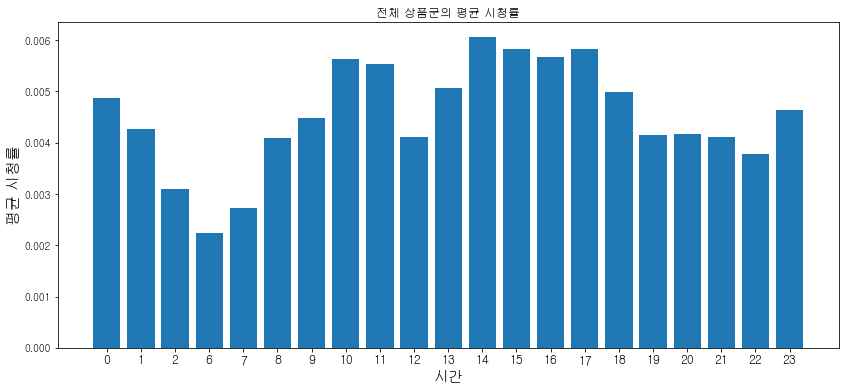

In [74]:
title = '전체 상품군의 평균 시청률'

hours = [i for i in range(0,24)]
for i in range(3, 6):
    hours.remove(i) # 0~2시 + 6~23시
    
fig, ax = plt.subplots(figsize = (14, 6))
ax.bar(total_broad.index, total_broad['시청률'])
ax.set_xlabel('시간', fontsize = 15)
ax.set_xticks(np.arange(len(hours)))
ax.set_ylabel('평균 시청률', fontsize = 15)
ax.set_xticklabels(hours, fontsize = 12)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

- 전체 상품군에 대한 시간대별 시청률 : 14시 > 17시 > 15시 순서이다.   

- 각 상품군(가구)에 대한 시간대별 시청률 : 10시 > 6시 > 7시 순서이다.   

즉, 상품군별 프라임 타임이 다른 것을 확인할 수 있다.

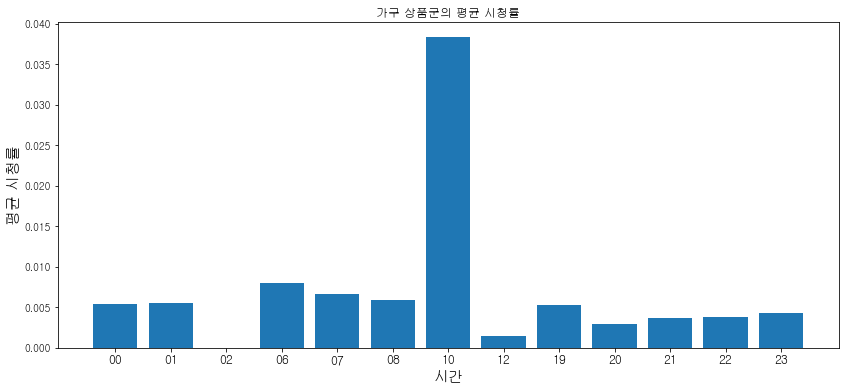

In [75]:
furniture_broad = pd.DataFrame(cate_broad.loc[cate_broad['상품군'] == '가구']).set_index('hour')

title = '가구 상품군의 평균 시청률'
fig, ax = plt.subplots(figsize = (14, 6))
ax.bar(furniture_broad.index, furniture_broad['시청률'])
ax.set_xlabel('시간', fontsize = 15)
ax.set_ylabel('평균 시청률', fontsize = 15)
ax.set_xticks(np.arange(len(furniture_broad.index)))
ax.set_xticklabels(furniture_broad.index, fontsize = 12)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

가장 대표적인 상품군 하나인 가구 상품을 보자.

- 가구 상품군의 평균 시청률 시간은 10시가 가장 높다.

## 계절

- 3,4,5 월 : 봄
- 6,7,8 월 : 여름
- 9,10,11월 : 가을
- 12,1,2월 : 겨울

In [76]:
# Train에서 season 변수 생성
print('변수 추가되기 이전의 데이터 형태 : ', train_raw.shape)
train_raw['season']=pd.Series()

for i in tqdm(range(len(train_raw))):
    temp = train_raw.loc[i,'month']
    if temp in ['03','04','05']:
        train_raw.loc[i,'season'] = 0.0 # 봄
    elif temp in ['06','07','08']:
        train_raw.loc[i,'season'] = 1.0 # 여름
    elif temp in ['09','10','11']:
        train_raw.loc[i,'season'] = 2.0 # 가을
    else:
        train_raw.loc[i,'season'] = 3.0 # 겨울
        
train_raw['season']=train_raw['season'].astype('object')

print('변수 추가되기 이후의 형태 : ', train_raw.shape)

변수 추가되기 이전의 데이터 형태 :  (35379, 17)



변수 추가되기 이후의 형태 :  (35379, 18)


### 막대 그래프를 통한 변수의 유의성 시각화

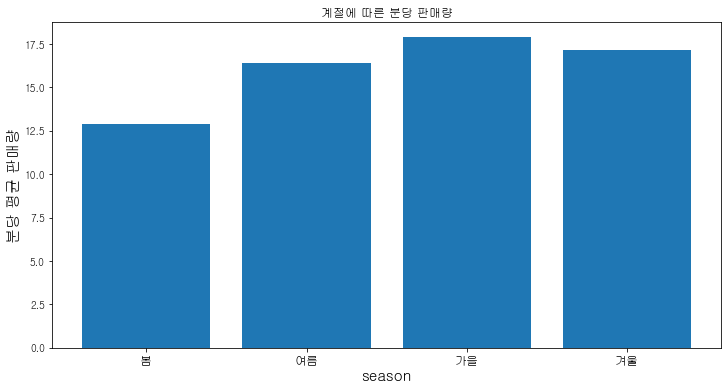

In [77]:
# 계절별 평균 판매량 그래프
season_group_df = train_raw['판매량'].groupby(train_raw['season']).mean()

fig, ax = plt.subplots(figsize = (12, 6))
title = '계절에 따른 분당 판매량'
ax.bar(season_group_df.index, season_group_df)
ax.set_xlabel('season', fontsize = 15)
ax.set_xticks(season_group_df.index)
ax.set_ylabel('분당 평균 판매량', fontsize = 15)
ax.set_xticklabels(['봄', '여름', '가을', '겨울'], fontsize = 12)
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

- 계절에 따라 전체 평균 분당 판매량의 차이가 존재함을 알 수 있다.   

- 특히, 가을의 분당 판매량이 가장 높은 것으로 나타났다.   

- 따라서 계절 요인은 분당 판매량에 영향을 미치는 것으로 보인다.

In [78]:
# Test에서 season 변수 생성
print('변수 추가되기 이전의 데이터 형태 : ', test_raw.shape)
test_raw['season']=pd.Series()

for i in tqdm(range(len(test_raw))):
    temp = test_raw.loc[i,'month']
    if temp in ['03','04','05']:
        test_raw.loc[i,'season'] = 0.0 # 봄
    elif temp in ['06','07','08']:
        test_raw.loc[i,'season'] = 1.0 # 여름
    elif temp in ['09','10','11']:
        test_raw.loc[i,'season'] = 2.0 # 가을
    else:
        test_raw.loc[i,'season'] = 3.0 # 겨울

test_raw['season']=test_raw['season'].astype('object')

print('변수 추가되기 이후의 데이터 형태 : ', test_raw.shape)

변수 추가되기 이전의 데이터 형태 :  (2716, 17)



변수 추가되기 이후의 데이터 형태 :  (2716, 18)


## 방송순서

In [79]:
train_raw.head(10)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand,date,hour,weekday,month,초중말,day,prime,season
0,2019-01-01 06:00:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,2099000,3.0,0.0,2019-01-01,06,0,01,0,1,0.0,3
1,2019-01-01 06:00:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,4371000,5.0,0.0,2019-01-01,06,0,01,0,1,0.0,3
2,2019-01-01 06:20:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,3262000,4.0,0.0,2019-01-01,06,0,01,0,1,0.0,3
3,2019-01-01 06:20:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,6955000,9.0,0.0,2019-01-01,06,0,01,0,1,0.0,3
4,2019-01-01 06:40:00,20,100346,201072,테이트 남성 셀린니트3종,의류,39900,6672000,8.0,0.0,2019-01-01,06,0,01,0,1,0.0,3
5,2019-01-01 06:40:00,20,100346,201079,테이트 여성 셀린니트3종,의류,39900,9337000,12.0,0.0,2019-01-01,06,0,01,0,1,0.0,3
6,2019-01-01 07:00:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,6819000,6.0,0.0,2019-01-01,07,0,01,0,1,0.0,3
7,2019-01-01 07:20:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,15689000,13.0,0.0,2019-01-01,07,0,01,0,1,0.0,3
8,2019-01-01 07:40:00,20,100305,200974,오모떼 레이스 파운데이션 브라,속옷,59000,25370000,22.0,0.0,2019-01-01,07,0,01,0,1,0.0,3
9,2019-01-01 08:00:00,20,100808,202377,CERINI by PAT 남성 소프트 기모 릴렉스팬츠,의류,59900,16133000,13.0,1.0,2019-01-01,08,0,01,0,1,0.0,3


데이터를 살펴봤을 때, 방송 시간이 마감이 되어갈수록 상품의 판매량이 증가하는 것을 볼 수 있다.   

이를 보고 방송순서에 따른 판매량의 차이가 유의미함을 확인할 수 있다.

In [80]:
# Train 방송순서 변수 생성
train_raw['방송순서'] = 0.0
for i in tqdm(list(train_raw['date'].unique())):
    temp = list(train_raw.loc[train_raw['date']==i,'상품코드'].unique())
    for j in temp:
        train_raw.loc[(train_raw['date']==i)&(train_raw['상품코드']==j),'방송순서']=\
        range(len(train_raw.loc[(train_raw['date']==i)&(train_raw['상품코드']==j),'방송순서']))

In [81]:
sequence_11 = list(train_raw.loc[train_raw['방송순서'] == 11.0]['상품명'])
time_11 = list(train_raw.loc[train_raw['방송순서'] == 11.0]['date'])
print(len(sequence_11)) ; print(len(time_11))

3
3


In [82]:
for i, v in enumerate(zip(sequence_11, time_11)):
    print(train_raw.loc[(train_raw['상품명'] == v[0]) & (train_raw['date'] == v[1])])
    print('-'*50)

                      방송일시 노출(분)    마더코드    상품코드              상품명 상품군   판매단가  \
14854  2019-05-31 15:00:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14855  2019-05-31 15:10:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14856  2019-05-31 15:20:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14857  2019-05-31 15:30:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14858  2019-05-31 15:40:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14859  2019-05-31 15:50:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14894  2019-05-31 20:00:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14895  2019-05-31 20:10:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14896  2019-05-31 20:20:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14897  2019-05-31 20:30:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14898  2019-05-31 20:40:00    10  100281  201009  에버라스트 드로즈 10+4종  속옷  39900   
14899  2019-05-31 20:50:00    10  100281

### 막대 그래프를 통한 변수의 유의성 시각화

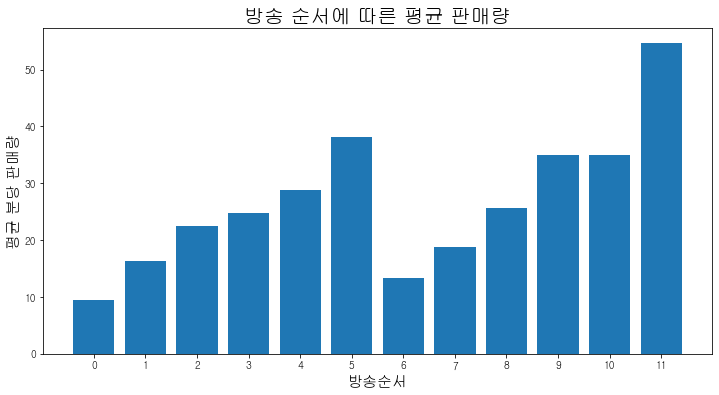

In [83]:
seq_group_df=train_raw['판매량'].groupby(train_raw['방송순서']).mean()

title = '방송 순서에 따른 평균 판매량'
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(list(seq_group_df.index), seq_group_df)
ax.set_xlabel('방송순서', fontsize = 15)
ax.set_xticks([i for i in range(0, 12)])
ax.set_ylabel('평균 분당 판매량',fontsize=15)
ax.set_title(title, fontsize= 20)
plt.savefig(f'./graphs/{title}.png')
plt.show()

동일한 상품이 일정 시각에 따라 연속으로 방송되는 경우를 방송 순서로 각각 지정한 결과,

방송 순서가 후에 이어질수록 **분당 판매량**이 증가하는 경향을 보이고 있다

In [84]:
# Test 방송순서 변수 생성
test_raw['방송순서'] = 0.0
for i in tqdm(list(test_raw['date'].unique())):
    temp = list(test_raw.loc[test_raw['date']==i,'상품코드'].unique())
    for j in temp:
        test_raw.loc[(test_raw['date']==i)&(test_raw['상품코드']==j),'방송순서']=\
        range(len(test_raw.loc[(test_raw['date']==i)&(test_raw['상품코드']==j),'방송순서']))

## 가격경쟁

In [85]:
train_raw.loc[train_raw['판매량'] == train_raw['판매량'].max()]

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand,date,hour,weekday,month,초중말,day,prime,season,방송순서
33043,2019-12-07 01:40:00,17.1667,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,322009000,470.0,1.0,2019-12-07,01,1,12,0,7,0.0,3,1.0


In [86]:
best_production = train_raw.loc[train_raw['상품명'] == '코몽트 덤블 플리스 자켓 2종']
best_production

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand,date,hour,weekday,month,초중말,day,prime,season,방송순서
31699,2019-11-22 01:20:00,20,100418,201323,코몽트 덤블 플리스 자켓 2종,의류,49900,12582000,13.0,1.0,2019-11-22,01,0,11,2,22,0.0,2,0.0
31700,2019-11-22 01:40:00,17.1833,100418,201323,코몽트 덤블 플리스 자켓 2종,의류,49900,17703000,21.0,1.0,2019-11-22,01,0,11,2,22,0.0,2,1.0
31701,2019-11-22 02:00:00,20,100418,201323,코몽트 덤블 플리스 자켓 2종,의류,49900,38854000,39.0,1.0,2019-11-22,02,0,11,2,22,1.0,2,2.0
32679,2019-12-03 01:20:00,20,100418,201323,코몽트 덤블 플리스 자켓 2종,의류,49900,16446000,16.0,1.0,2019-12-03,01,0,12,0,3,0.0,3,0.0
32680,2019-12-03 01:40:00,17.1667,100418,201323,코몽트 덤블 플리스 자켓 2종,의류,49900,21949000,26.0,1.0,2019-12-03,01,0,12,0,3,0.0,3,1.0
32681,2019-12-03 02:00:00,20,100418,201323,코몽트 덤블 플리스 자켓 2종,의류,49900,27049000,27.0,1.0,2019-12-03,02,0,12,0,3,1.0,3,2.0
33042,2019-12-07 01:20:00,20,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,23722000,30.0,1.0,2019-12-07,01,1,12,0,7,0.0,3,0.0
33043,2019-12-07 01:40:00,17.1667,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,322009000,470.0,1.0,2019-12-07,01,1,12,0,7,0.0,3,1.0
33053,2019-12-07 08:20:00,20,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,56318000,71.0,1.0,2019-12-07,08,1,12,0,7,0.0,3,2.0
33054,2019-12-07 08:40:00,20,100418,201322,코몽트 덤블 플리스 자켓 2종,의류,39900,104910000,131.0,1.0,2019-12-07,08,1,12,0,7,0.0,3,3.0


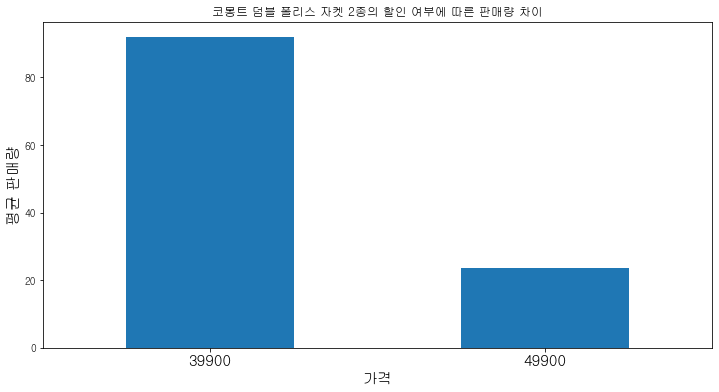

In [87]:
discount_df = best_production['판매량'].groupby(best_production['판매단가']).mean()

title = '코몽트 덤블 폴리스 자켓 2종의 할인 여부에 따른 판매량 차이'
index = np.arange(len(discount_df))
discount_df.plot(kind = 'bar', figsize = (12, 6))
plt.title(title)
plt.xlabel('가격', size = 15)
plt.xticks(index, rotation = 0, size = 15)
plt.ylabel('평균 판매량', size = 15)
plt.savefig(f'./graphs/{title}.png')
plt.show()

- 가장 많이 팔린 상품을 보았을 때, 할인한 가격의 평균 판매량이 그렇지 않은 가격의 평균 판매량 보다 3배 이상 높은 것을 볼 수 있다.   

**할인 여부** 변수를 생성하고 판매량에 유의미한 차이를 주는지 살펴보자

In [88]:
# Train에서 discount 변수 생성
prod_code = list(train_raw['상품명'].unique())
discount_idx = list()
for i in prod_code:
    temp = train_raw.loc[train_raw['상품명']==i,'판매단가']
    max_value = temp.max()
    for j in range(len(temp)):
        if temp.iloc[j] < max_value:
            discount_idx.append(temp.index[j])
train_raw['discount'] = 0.0 # 비 할인
train_raw.loc[discount_idx,'discount'] = 1.0 # 할인

In [89]:
discount_product = train_raw.loc[discount_idx, '상품명'].unique() # 할인 상품 목록
discount_product[:3]

array(['보코 리버시블 무스탕', '멋진밥상 흥양농협 햅쌀 20kg', '마리노블 밍크 롱코트'], dtype=object)

In [90]:
# 할인을 한 적 있는 상품에 한해서만 비교 분석 진행
# 할인을 한 적 없는 상품들까지 모두 들어오면, 할인하지 않아도 인기 많은 몇몇 상품때문에 정확한 비교 분석 불가
discount_df = pd.DataFrame()
for name in discount_product:
    temp = train_raw.loc[train_raw['상품명'] == name]
    discount_df = pd.concat([discount_df, temp], axis = 0)
    
discount_df = discount_df.reset_index(drop = True)
discount_df.head(5)

,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,판매량,brand,date,hour,weekday,month,초중말,day,prime,season,방송순서,discount
0,2019-01-01 09:00:00,20,100816,202404,보코 리버시블 무스탕,의류,79000,16075000,10.0,0.0,2019-01-01,09,0,01,0,1,0.0,3,0.0,0.0
1,2019-01-01 09:20:00,20,100816,202404,보코 리버시블 무스탕,의류,79000,25628000,16.0,0.0,2019-01-01,09,0,01,0,1,0.0,3,1.0,0.0
2,2019-01-01 09:40:00,20,100816,202404,보코 리버시블 무스탕,의류,79000,49270000,31.0,0.0,2019-01-01,09,0,01,0,1,0.0,3,2.0,0.0
3,2019-01-03 11:00:00,20,100816,202404,보코 리버시블 무스탕,의류,79000,16785000,11.0,0.0,2019-01-03,11,0,01,0,3,0.0,3,0.0,0.0
4,2019-01-03 11:20:00,20,100816,202404,보코 리버시블 무스탕,의류,79000,32391000,21.0,0.0,2019-01-03,11,0,01,0,3,0.0,3,1.0,0.0


### 막대 그래프를 통한 변수의 유의성 시각화

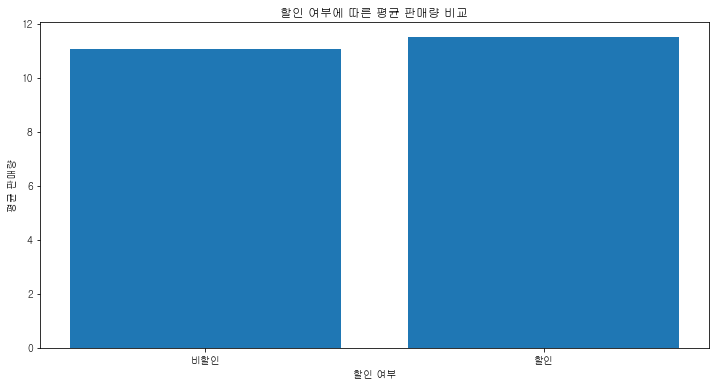

In [91]:
discount_group_df = discount_df.groupby(['discount'])['판매량'].mean()

title = '할인 여부에 따른 평균 판매량 비교'
fig,ax = plt.subplots(figsize = (12, 6))
ax.bar(discount_group_df.index, discount_group_df)
ax.set_xlabel('할인 여부')
ax.set_xticks(np.arange(len(discount_group_df.index)))
ax.set_ylabel('평균 판매량')
ax.set_xticklabels(['비할인', '할인'])
ax.set_title(title)
plt.savefig(f'./graphs/{title}.png')
plt.show()

할인 한 적이 있던 상품들에 한하여, 할인 여부에 따른 판매량을 비교해보았을 때, 할인한 경우 평균 판매량이 높은 것을 볼 수 있다.   

### T-Test

- H0 : 할인 여부에 따른 평균 판매량은 차이가 없다.
- H1 : 할인 여부에 따른 평균 판매량은 차이가 있다.

In [92]:
group_discount = train_raw.loc[train_raw['discount'] == 1] # 주말
group_notdiscount = train_raw.loc[train_raw['discount'] == 0] # 주중

print('프라임 타임 데이터 형태 : ', group_discount.shape)
print('비 프라임 타임 데이터 형태 : ', group_notdiscount.shape)

프라임 타임 데이터 형태 :  (3865, 20)
비 프라임 타임 데이터 형태 :  (31514, 20)


In [93]:
# levene 등분산 검정
lresult = stats.levene(group_discount['판매량'], group_notdiscount['판매량'])
print('LeveneResult(F) : %.3f \np-value : %.3f' % (lresult)) # p-value : 0.000 으로 이분산성

LeveneResult(F) : 110.783 
p-value : 0.000


In [94]:
# 등분산이 아닌 독립표본 t-검정 실행 
t_result = stats.ttest_ind(group_discount['판매량'], group_notdiscount['판매량'], equal_var=False) 
print('t statistic : %.3f \np-value : %.3f' % (t_result))

t statistic : -14.360 
p-value : 0.000


p-value 0.000으로 0.05보다 작으므로 귀무가설을 기각한다.   

즉, 비 할인 상품과 할인 상품의의 분당 평균 판매량은 다르다고 말 할 수 있다.

In [95]:
# Test에서 discount 변수 생성
# Test Data내에서 할인된 상품

prod_code = list(test_raw['상품명'].unique())
discount_idx = list()
for i in prod_code:
    temp = test_raw.loc[test_raw['상품명']==i,'판매단가']
    max_value = temp.max()
    for j in range(len(temp)):
        if temp.iloc[j] < max_value:
            discount_idx.append(temp.index[j])
            
test_raw['discount'] = 0.0 # 비 할인
test_raw.loc[discount_idx,'discount'] = 1.0 # 할인

# 작년 판매 상품에 비해 할인된 상품
prod_code = list(set(train_raw['상품명']) & set(test_raw['상품명']))
for i in prod_code:
    temp_cost = train_raw.loc[train_raw['상품명']==i,'판매단가'].mean()
    test_raw.loc[(test_raw['상품명']==i)&(test_raw['판매단가']<temp_cost),'discount'] = 1.0
    
test_raw.head(3)

,index,방송일시,노출(분),마더코드,상품코드,상품명,상품군,판매단가,취급액,brand,date,hour,weekday,month,초중말,day,prime,season,방송순서,discount
0,1,2020-06-01 06:20:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0.0,2020-06-01,06,0,06,0,1,0.0,1,0.0,0.0
1,2,2020-06-01 06:40:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0.0,2020-06-01,06,0,06,0,1,0.0,1,1.0,0.0
2,3,2020-06-01 07:00:00,20,100650,201971,잭필드 남성 반팔셔츠 4종,의류,59800,NaN,0.0,2020-06-01,07,0,06,0,1,0.0,1,2.0,0.0


In [96]:
with open('./pickles/train.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(train_raw, f)

with open('./pickles/test.pkl', 'wb') as f: # 완성된 데이터 셋 pickle 형태로 저장
    pickle.dump(test_raw, f)

print(train_raw.head(3))
print('-'*50)
print(test_raw.head(3))

                  방송일시 노출(분)    마더코드    상품코드            상품명 상품군   판매단가  \
0  2019-01-01 06:00:00    20  100346  201072  테이트 남성 셀린니트3종  의류  39900   
1  2019-01-01 06:00:00    20  100346  201079  테이트 여성 셀린니트3종  의류  39900   
2  2019-01-01 06:20:00    20  100346  201072  테이트 남성 셀린니트3종  의류  39900   

       취급액  판매량  brand        date hour weekday month 초중말 day  prime season  \
0  2099000  3.0    0.0  2019-01-01   06       0    01   0   1    0.0      3   
1  4371000  5.0    0.0  2019-01-01   06       0    01   0   1    0.0      3   
2  3262000  4.0    0.0  2019-01-01   06       0    01   0   1    0.0      3   

   방송순서  discount  
0   0.0       0.0  
1   0.0       0.0  
2   1.0       0.0  
--------------------------------------------------
   index                 방송일시 노출(분)    마더코드    상품코드              상품명 상품군  \
0      1  2020-06-01 06:20:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   
1      2  2020-06-01 06:40:00    20  100650  201971  잭필드 남성  반팔셔츠 4종  의류   
2      3  2020-06-01 07:00: